In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(64,64)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]

    def random_op(self):
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
        
        batch_size=len(input)
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        #print(V_output.size())
        #Q_grid, K_grid=torch.meshgrid(Q_output, K_output, indexing='ij')
        alpha=torch.exp(-(Q_output-K_output)**2)
        alpha=alpha.transpose(0,1)
        print(f'alpha: {alpha}')
        # Example usage:
        visualize_attention(alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        print("Q_output size:", Q_output.size())
        print("K_output size:", K_output.size())
        print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 1)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [5]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# 클래스 0과 1에 해당하는 데이터만 선택 (test set)
test_mask = np.isin(y_test_full, selected_classes)
X_test_filtered = X_test_gray[test_mask.squeeze()]
y_test_filtered = y_test_full[test_mask.squeeze()]

# 클래스 라벨을 이진 라벨로 변환 (0 또는 1로)
y_train_filtered = (y_train_filtered == selected_classes[1]).astype(int)
y_test_filtered = (y_test_filtered == selected_classes[1]).astype(int)

# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 200
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


2024-10-14 21:53:47.485796: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 21:53:47.486736: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 21:53:47.490526: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 21:53:47.503013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 21:53:47.522598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Training set size: 160
Test set size: 40
Sampled train labels: [0 1]
Sampled test labels: [0 1]


In [6]:
# from sklearn.datasets import load_digits
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.image import extract_patches_2d

# digits = load_digits()
# X, y = digits.images, digits.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# train_mask = np.isin(y_train, [1, 7])
# X_train, y_train = X_train[train_mask], y_train[train_mask]

# test_mask = np.isin(y_test, [1, 7])
# X_test, y_test = X_test[test_mask], y_test[test_mask]

# #
# # X_train = X_train.reshape(X_train.shape[0], 16, 4)
# # X_test = X_test.reshape(X_test.shape[0], 16, 4)

In [7]:
X_train.shape

(160, 32, 32)

In [8]:
X_test.shape

(40, 32, 32)

In [9]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [10]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [11]:
# # (283, 16, 2, 2)를 (283, 16, 4)로 변환
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [12]:
# # 이미지 패치 나누기 (2x2 크기 패치)
# patch_size = (2, 2)

# # 각 이미지를 개별적으로 패치로 나누기
# X_train = np.array([extract_patches_2d(img, patch_size) for img in X_train])
# X_test = np.array([extract_patches_2d(img, patch_size) for img in X_test])

In [13]:
X_train.shape

(160, 64, 16)

In [14]:
X_train

array([[[0.68392943, 0.6815412 , 0.68497257, ..., 0.76893727,
         0.76659217, 0.78227844],
        [0.70445492, 0.67137649, 0.46515295, ..., 0.1654353 ,
         0.35371373, 0.76740001],
        [0.74089805, 0.73669805, 0.7232706 , ..., 0.77814511,
         0.7624157 , 0.51531373],
        ...,
        [0.42566667, 0.48869021, 0.51149413, ..., 0.61409022,
         0.60315296, 0.60198042],
        [0.55667454, 0.58433728, 0.61521963, ..., 0.60287453,
         0.61370198, 0.62340002],
        [0.6474863 , 0.65941963, 0.67676865, ..., 0.64737649,
         0.66540786, 0.67887845]],

       [[0.82471766, 0.83228236, 0.83741962, ..., 0.85775295,
         0.64949022, 0.18106275],
        [0.84296079, 0.84016864, 0.83373334, ..., 0.14673334,
         0.16343922, 0.39753334],
        [0.82356472, 0.82654903, 0.82840393, ..., 0.85992942,
         0.85500393, 0.85698432],
        ...,
        [0.5690314 , 0.90258432, 0.9450902 , ..., 0.27663531,
         0.27440001, 0.33927844],
        [0.9

In [15]:
    # def circuit_v(self,inputs,weights):
    #         op=self.random_op()
    #         # feature_map
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(inputs[indx],j)
    #             qml.RY(inputs[indx+1],j)
    #             indx+=2
    #         for i in range(self.Denc):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))

    #             for j in range(self.num_q):
    #                 qml.RY(inputs[indx],j)
    #                 indx+=1
    #         # Ansatz
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(weights[indx],j)
    #             qml.RY(weights[indx+1],j)
    #             indx+=2
    #         for i in range(self.D):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
    #             for j in range(self.num_q):
    #                 #qc.rx(params[indx],j)
    #                 qml.RY(weights[indx],j)
    #                 indx+=1
    #         return [qml.expval(op) for i in range(self.d)] 

In [16]:
model=QSANN_text_classifier(64, 4, 2, 1, 1)

# seq * (num_qubits) * (num_layers + 2)

In [17]:
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

In [18]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

3329


In [19]:
criterion = torch.nn.CrossEntropyLoss()

In [20]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [21]:
torch.tensor(X_train)

tensor([[[0.6839, 0.6815, 0.6850,  ..., 0.7689, 0.7666, 0.7823],
         [0.7045, 0.6714, 0.4652,  ..., 0.1654, 0.3537, 0.7674],
         [0.7409, 0.7367, 0.7233,  ..., 0.7781, 0.7624, 0.5153],
         ...,
         [0.4257, 0.4887, 0.5115,  ..., 0.6141, 0.6032, 0.6020],
         [0.5567, 0.5843, 0.6152,  ..., 0.6029, 0.6137, 0.6234],
         [0.6475, 0.6594, 0.6768,  ..., 0.6474, 0.6654, 0.6789]],

        [[0.8247, 0.8323, 0.8374,  ..., 0.8578, 0.6495, 0.1811],
         [0.8430, 0.8402, 0.8337,  ..., 0.1467, 0.1634, 0.3975],
         [0.8236, 0.8265, 0.8284,  ..., 0.8599, 0.8550, 0.8570],
         ...,
         [0.5690, 0.9026, 0.9451,  ..., 0.2766, 0.2744, 0.3393],
         [0.9179, 0.9178, 0.8760,  ..., 0.9317, 0.9329, 0.9254],
         [0.9438, 0.9573, 0.9261,  ..., 0.9387, 0.9122, 0.9198]],

        [[0.5241, 0.5218, 0.5280,  ..., 0.4737, 0.4737, 0.4569],
         [0.5285, 0.5251, 0.5133,  ..., 0.4346, 0.4362, 0.4452],
         [0.4899, 0.4664, 0.4507,  ..., 0.4428, 0.4350, 0.

  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9985, 0.9972, 0.9908,  ..., 0.9647, 0.9179, 0.9183],
         [0.7853, 0.7740, 0.8802,  ..., 0.9328, 0.9745, 0.9743],
         [0.7668, 0.7552, 0.8649,  ..., 0.9207, 0.9666, 0.9663],
         ...,
         [0.8444, 0.8342, 0.9262,  ..., 0.9669, 0.9936, 0.9935],
         [0.8570, 0.8470, 0.9353,  ..., 0.9731, 0.9962, 0.9961],
         [0.9972, 0.9954, 0.9934,  ..., 0.9700, 0.9257, 0.9262]],

        [[0.8061, 0.8129, 1.0000,  ..., 0.9857, 0.9999, 0.9718],
         [0.8679, 0.8739, 0.9910,  ..., 0.9990, 0.9900, 0.9934],
         [0.6783, 0.6861, 0.9772,  ..., 0.9252, 0.9788, 0.8981],
         ...,
         [0.7875, 0.7946, 0.9997,  ..., 0.9793, 0.9999, 0.9632],
         [0.9997, 0.9999, 0.8140,  ..., 0.8988, 0.8101, 0.9259],
         [0.8054, 0.8122, 1.0000,  ..., 0.9855, 0.9999, 0.9715]],

        [[0.9848, 0.9938, 0.6739,  ..., 0.9586, 0.8620, 0.9329],
         [0.9112, 0.9346, 0.5195,  ..., 0.8611, 0.7256, 0.8206],
         [0.6115, 0.6499, 0.2337,  ..., 0.5416, 0.3

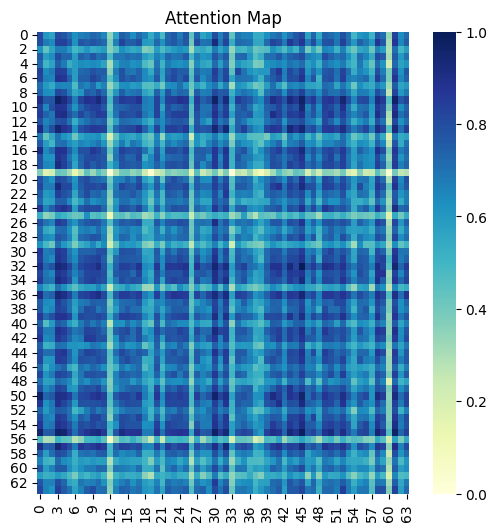

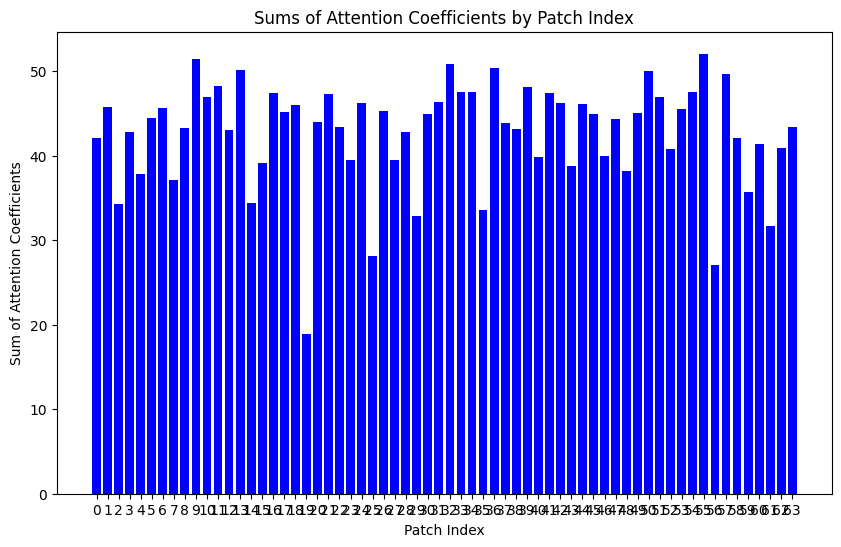

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])

Accuracy: tensor(0.4375)

tensor(441.2401, grad_fn=<DivBackward1>)


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
  3%|▎         | 1/30 [14:30<7:00:32, 870.10s/it]

Complete 0 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9284, 0.9272, 0.9809,  ..., 0.9998, 0.9037, 0.9987],
         [0.7220, 0.9995, 0.8262,  ..., 0.9228, 0.6839, 0.8946],
         [0.9061, 0.9470, 0.9680,  ..., 0.9993, 0.8786, 0.9941],
         ...,
         [0.7230, 0.9995, 0.8271,  ..., 0.9234, 0.6850, 0.8954],
         [0.9875, 0.8273, 0.9995,  ..., 0.9697, 0.9755, 0.9845],
         [0.9112, 0.9428, 0.9712,  ..., 0.9997, 0.8844, 0.9954]],

        [[0.8820, 0.7554, 0.9760,  ..., 0.7790, 0.5956, 0.7631],
         [0.8401, 0.9431, 0.6844,  ..., 0.9287, 0.9973, 0.9385],
         [0.9990, 0.9796, 0.9484,  ..., 0.9872, 0.8946, 0.9823],
         ...,
         [0.9523, 0.8546, 0.9995,  ..., 0.8743, 0.7089, 0.8612],
         [0.9026, 0.7823, 0.9853,  ..., 0.8051, 0.6249, 0.7898],
         [0.9707, 0.8862, 0.9993,  ..., 0.9040, 0.7488, 0.8921]],

        [[0.8580, 0.9640, 0.9753,  ..., 0.9976, 0.9314, 0.8492],
         [0.9962, 0.9811, 0.9710,  ..., 0.9244, 0.9960, 0.9944],
         [0.9824, 0.9956, 0.9901,  ..., 0.9574, 0.9

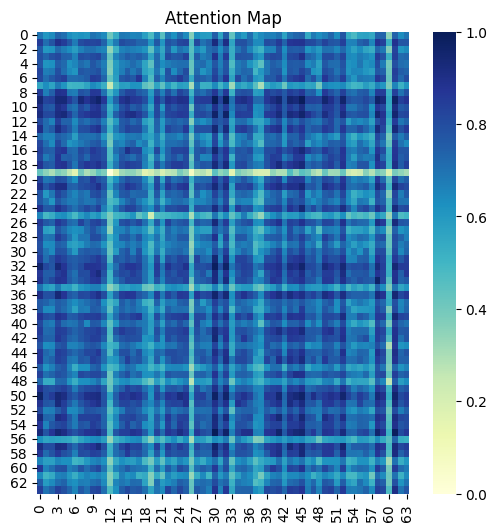

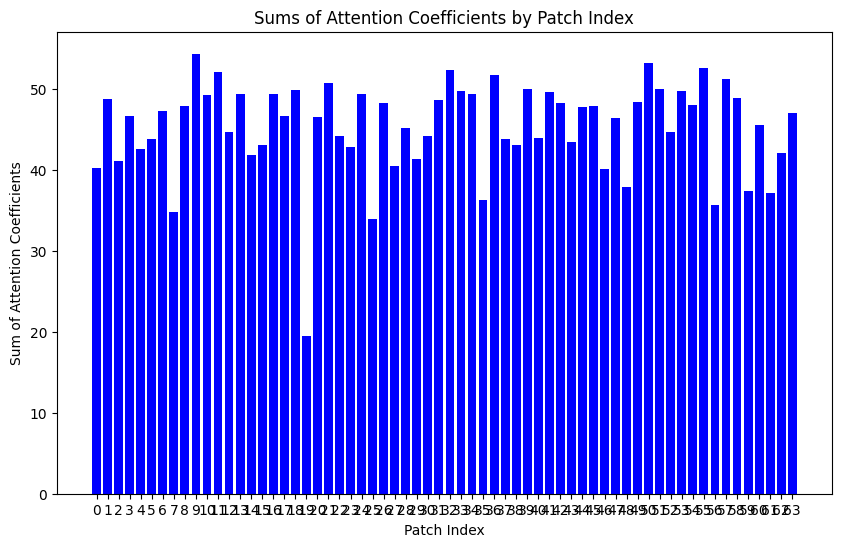

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.5437)

tensor(440.3054, grad_fn=<DivBackward1>)


  7%|▋         | 2/30 [30:49<7:16:06, 934.51s/it]

Complete 1 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9942, 0.9612, 0.8731,  ..., 0.9977, 0.9158, 0.9710],
         [0.9884, 0.8636, 0.7371,  ..., 0.9817, 0.9874, 0.9998],
         [0.8115, 0.5852, 0.4438,  ..., 0.7904, 0.9456, 0.8775],
         ...,
         [0.9432, 0.7655, 0.6245,  ..., 0.9297, 0.9995, 0.9788],
         [0.9837, 0.9787, 0.9049,  ..., 0.9900, 0.8855, 0.9512],
         [0.9995, 0.9378, 0.8364,  ..., 1.0000, 0.9430, 0.9864]],

        [[0.9999, 0.9952, 0.9405,  ..., 0.8571, 0.9997, 0.9125],
         [0.9714, 0.9873, 0.9957,  ..., 0.7185, 0.9604, 0.9856],
         [0.9998, 0.9982, 0.9523,  ..., 0.8388, 0.9980, 0.9267],
         ...,
         [0.9880, 0.9972, 0.9843,  ..., 0.7674, 0.9805, 0.9678],
         [0.8819, 0.8440, 0.7059,  ..., 0.9975, 0.9005, 0.6596],
         [0.8879, 0.9206, 0.9882,  ..., 0.5702, 0.8684, 0.9971]],

        [[0.9971, 1.0000, 0.6092,  ..., 0.9978, 0.9999, 0.7494],
         [0.9980, 0.9999, 0.6170,  ..., 0.9986, 0.9996, 0.7567],
         [0.9530, 0.9725, 0.4692,  ..., 0.9556, 0.9

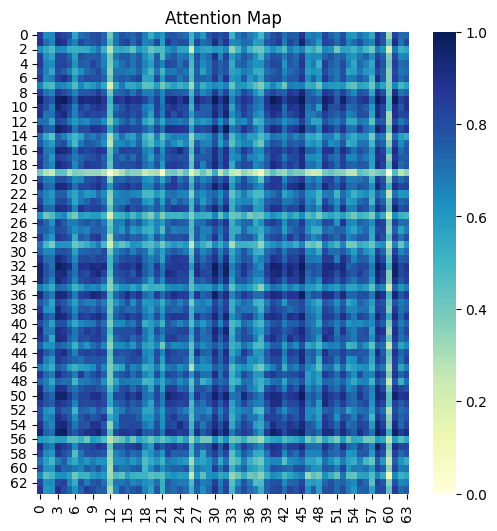

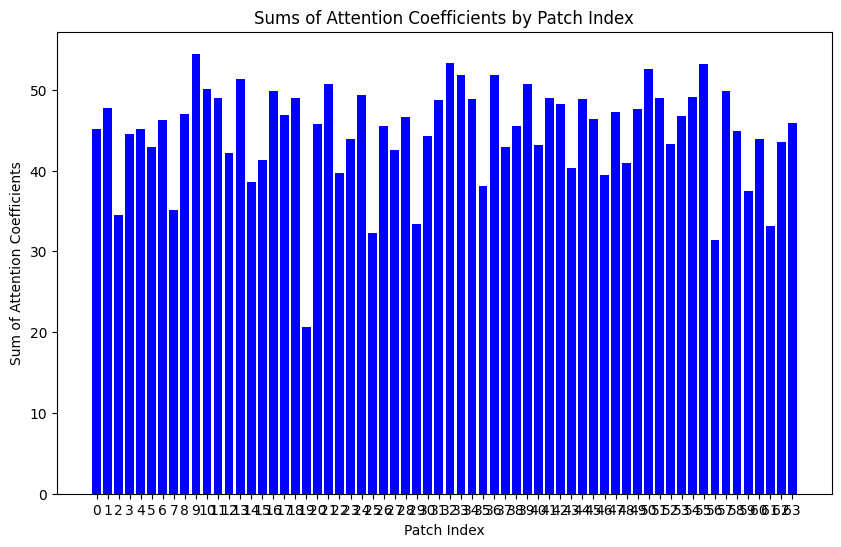

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.5437)

tensor(440.2687, grad_fn=<DivBackward1>)


 10%|█         | 3/30 [45:51<6:53:53, 919.77s/it]

Complete 2 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9611, 0.9931, 0.9989,  ..., 0.8963, 0.9118, 0.9992],
         [0.9240, 1.0000, 0.9977,  ..., 0.8434, 0.9519, 0.9971],
         [0.9441, 0.7613, 0.7999,  ..., 0.9884, 0.5759, 0.8041],
         ...,
         [0.9708, 0.8133, 0.8489,  ..., 0.9984, 0.6339, 0.8526],
         [0.7360, 0.9291, 0.9021,  ..., 0.6253, 0.9974, 0.8989],
         [0.9946, 0.9572, 0.9750,  ..., 0.9588, 0.8314, 0.9766]],

        [[0.9778, 0.9752, 0.9350,  ..., 0.9793, 0.9543, 0.8417],
         [0.9673, 0.9641, 0.9184,  ..., 0.9875, 0.9400, 0.8184],
         [0.9915, 0.9897, 0.9599,  ..., 0.9602, 0.9750, 0.8797],
         ...,
         [0.9917, 0.9900, 0.9605,  ..., 0.9596, 0.9754, 0.8806],
         [0.9256, 0.9301, 0.9720,  ..., 0.7208, 0.9563, 0.9998],
         [0.9547, 0.9509, 0.8997,  ..., 0.9938, 0.9236, 0.7936]],

        [[0.9805, 0.8564, 0.9361,  ..., 0.9997, 0.9800, 0.8813],
         [0.9648, 0.9959, 0.9947,  ..., 0.9076, 0.8004, 0.9993],
         [0.9988, 0.9204, 0.9774,  ..., 0.9924, 0.9

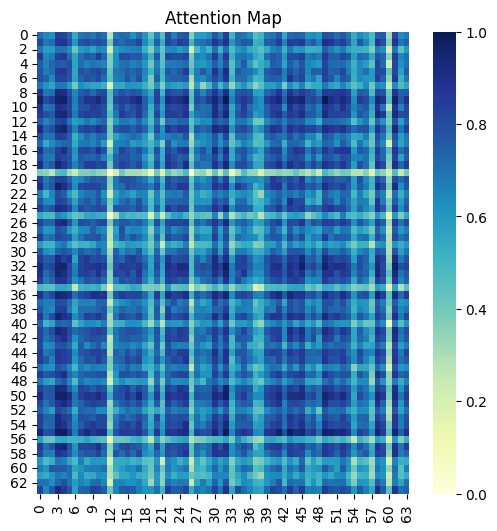

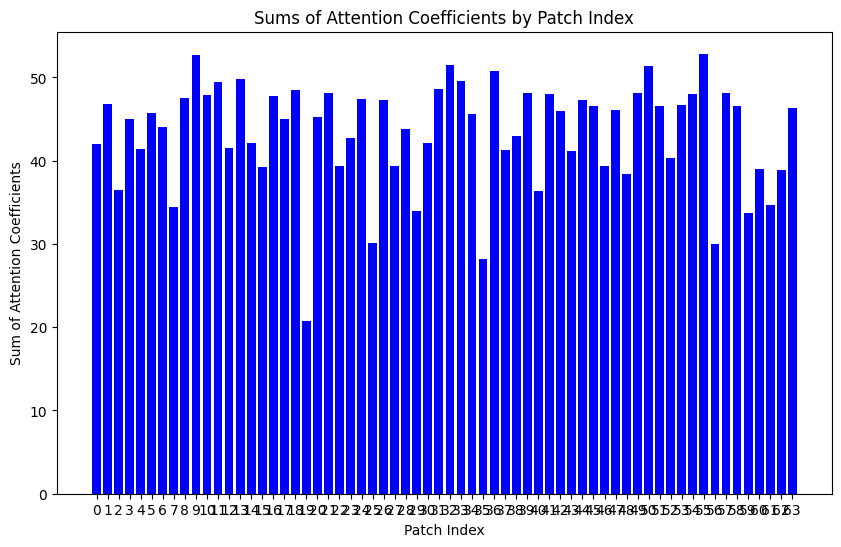

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.5562)

tensor(439.2523, grad_fn=<DivBackward1>)


 13%|█▎        | 4/30 [1:01:11<6:38:28, 919.56s/it]

Complete 3 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.7745, 0.8102, 0.9520,  ..., 0.7383, 1.0000, 0.7922],
         [0.9363, 0.9569, 0.9993,  ..., 0.9129, 0.9386, 0.9468],
         [0.9994, 0.9995, 0.9348,  ..., 0.9952, 0.7909, 1.0000],
         ...,
         [0.9240, 0.8981, 0.7269,  ..., 0.9459, 0.5362, 0.9118],
         [0.8419, 0.8082, 0.6140,  ..., 0.8724, 0.4264, 0.8257],
         [0.9741, 0.9574, 0.8199,  ..., 0.9865, 0.6380, 0.9664]],

        [[0.6685, 0.8133, 0.8586,  ..., 0.8618, 0.8011, 0.9193],
         [0.9732, 0.9998, 0.9937,  ..., 0.9930, 1.0000, 0.9683],
         [0.7799, 0.9035, 0.9373,  ..., 0.9396, 0.8939, 0.9765],
         ...,
         [0.9624, 0.9997, 0.9977,  ..., 0.9972, 0.9990, 0.9781],
         [0.7701, 0.8962, 0.9312,  ..., 0.9336, 0.8863, 0.9726],
         [0.9898, 0.9938, 0.9798,  ..., 0.9784, 0.9961, 0.9426]],

        [[0.6948, 0.8344, 0.9223,  ..., 0.7033, 0.9989, 0.9343],
         [0.9101, 0.9835, 0.9999,  ..., 0.9157, 0.9333, 0.9987],
         [0.9402, 0.9950, 0.9950,  ..., 0.9448, 0.9

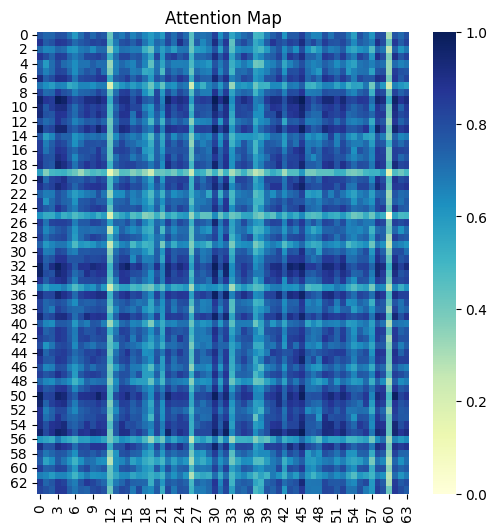

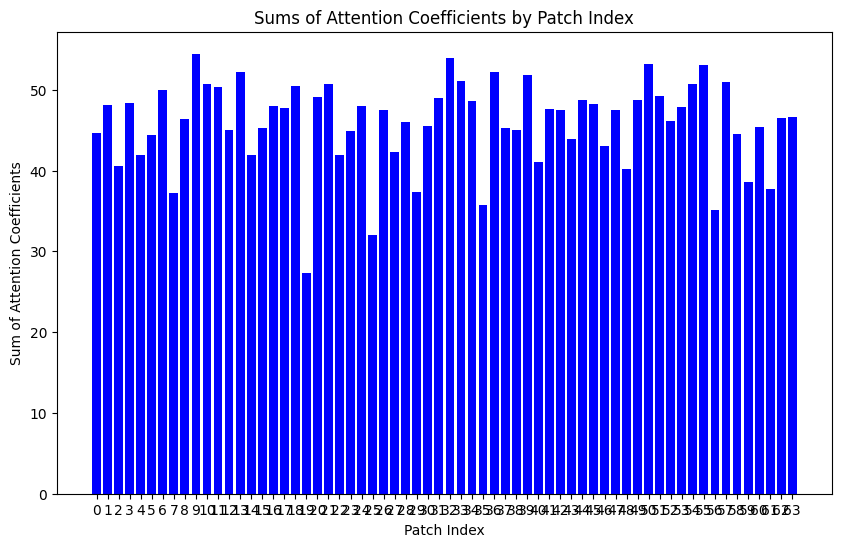

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.6125)

tensor(435.8747, grad_fn=<DivBackward1>)


 17%|█▋        | 5/30 [1:16:28<6:22:47, 918.70s/it]

Complete 4 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9019, 0.9926, 0.5724,  ..., 0.8819, 0.9949, 0.9926],
         [0.8611, 0.6793, 0.9985,  ..., 0.8825, 0.6669, 0.6794],
         [0.9899, 0.8934, 0.8998,  ..., 0.9954, 0.8844, 0.8934],
         ...,
         [0.9483, 1.0000, 0.6502,  ..., 0.9329, 0.9996, 1.0000],
         [0.9685, 0.8426, 0.9409,  ..., 0.9790, 0.8322, 0.8427],
         [0.9491, 0.8066, 0.9619,  ..., 0.9626, 0.7955, 0.8067]],

        [[0.9967, 0.9994, 0.8789,  ..., 0.8992, 0.8658, 0.9535],
         [0.9859, 0.9769, 0.9671,  ..., 0.9778, 0.9595, 0.9982],
         [0.9998, 0.9977, 0.9207,  ..., 0.9374, 0.9096, 0.9788],
         ...,
         [0.9765, 0.9653, 0.9784,  ..., 0.9869, 0.9721, 1.0000],
         [0.9975, 0.9930, 0.9386,  ..., 0.9534, 0.9286, 0.9878],
         [0.9086, 0.8888, 0.9999,  ..., 0.9983, 0.9998, 0.9781]],

        [[0.9713, 0.9641, 0.9889,  ..., 0.9991, 0.9909, 0.9102],
         [0.9252, 0.6633, 0.7348,  ..., 0.7950, 0.8822, 0.9798],
         [0.9477, 0.7030, 0.7725,  ..., 0.8298, 0.9

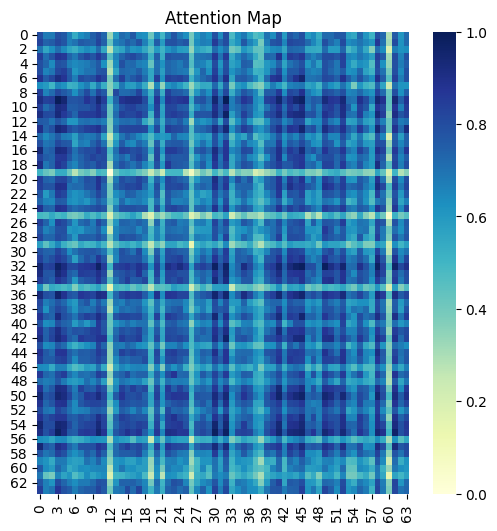

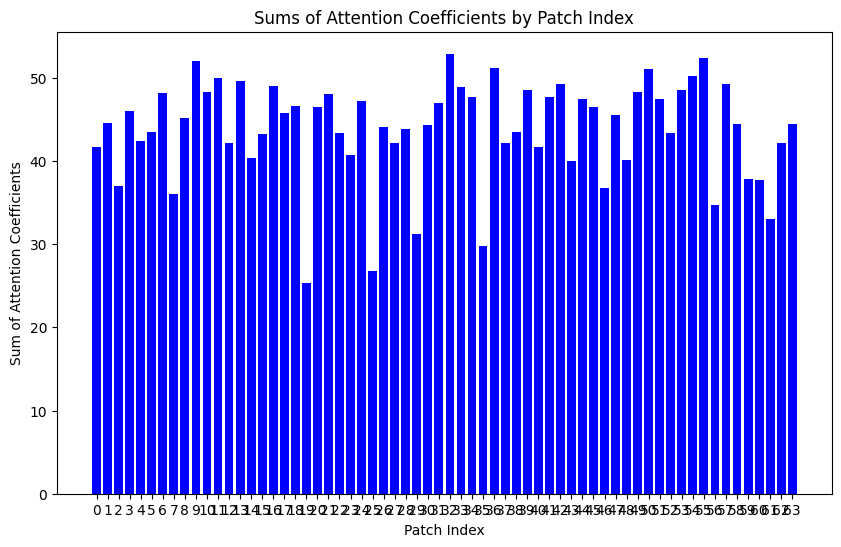

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.6500)

tensor(434.6314, grad_fn=<DivBackward1>)


 20%|██        | 6/30 [1:31:43<6:07:03, 917.66s/it]

Complete 5 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9532, 0.9770, 0.9140,  ..., 0.9997, 0.9269, 0.8037],
         [0.9519, 0.9201, 0.9803,  ..., 0.8366, 0.9730, 0.9993],
         [0.9968, 0.9849, 0.9994,  ..., 0.9360, 1.0000, 0.9639],
         ...,
         [0.8945, 0.9310, 0.8419,  ..., 0.9824, 0.8587, 0.7124],
         [0.9811, 0.9590, 0.9967,  ..., 0.8917, 0.9934, 0.9879],
         [0.9980, 0.9995, 0.9845,  ..., 0.9759, 0.9899, 0.9179]],

        [[0.9722, 0.9337, 0.9898,  ..., 0.9689, 0.9468, 0.9579],
         [0.9802, 0.9978, 0.8449,  ..., 0.9828, 0.9943, 0.7657],
         [0.9536, 0.9848, 0.7888,  ..., 0.9576, 0.9772, 0.7033],
         ...,
         [0.9916, 0.9660, 0.9691,  ..., 0.9897, 0.9754, 0.9228],
         [0.9776, 0.9420, 0.9860,  ..., 0.9746, 0.9542, 0.9507],
         [1.0000, 0.9912, 0.9300,  ..., 0.9999, 0.9957, 0.8684]],

        [[0.8938, 0.8826, 0.9966,  ..., 0.9083, 0.9916, 0.8026],
         [0.9620, 0.9547, 0.9937,  ..., 0.9709, 0.9979, 0.8964],
         [0.9892, 0.9851, 0.9708,  ..., 0.9937, 0.9

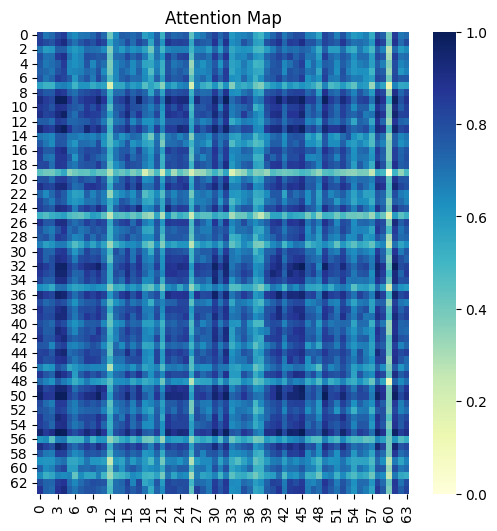

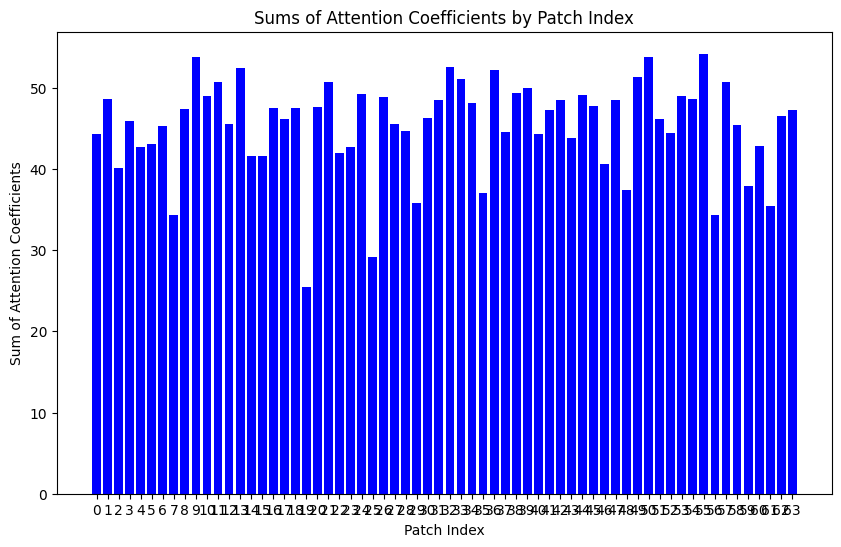

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.5813)

tensor(435.3944, grad_fn=<DivBackward1>)


 23%|██▎       | 7/30 [1:47:08<5:52:33, 919.74s/it]

Complete 6 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9009, 0.8575, 0.9258,  ..., 0.9995, 0.7478, 0.9551],
         [0.7619, 0.7056, 0.7972,  ..., 0.9527, 0.5805, 0.9997],
         [0.8386, 0.7877, 0.8694,  ..., 0.9861, 0.6677, 0.9862],
         ...,
         [0.8635, 0.8152, 0.8922,  ..., 0.9933, 0.6985, 0.9765],
         [0.9964, 0.9836, 0.9998,  ..., 0.9433, 0.9268, 0.7960],
         [0.9676, 0.9392, 0.9816,  ..., 0.9857, 0.8539, 0.8810]],

        [[0.7387, 0.9998, 0.8385,  ..., 0.9914, 0.8104, 0.7378],
         [0.8900, 0.9621, 0.9566,  ..., 0.9129, 0.9396, 0.8894],
         [0.9963, 0.6986, 0.9639,  ..., 0.6090, 0.9769, 0.9964],
         ...,
         [1.0000, 0.7542, 0.9847,  ..., 0.6669, 0.9928, 0.9999],
         [0.7637, 0.9997, 0.8599,  ..., 0.9848, 0.8330, 0.7629],
         [0.9890, 0.6612, 0.9458,  ..., 0.5711, 0.9619, 0.9892]],

        [[0.8040, 0.7429, 0.9788,  ..., 0.8473, 0.8072, 0.9999],
         [0.9975, 0.9837, 0.9294,  ..., 0.9999, 0.9979, 0.8333],
         [0.9891, 0.9993, 0.8345,  ..., 0.9732, 0.9

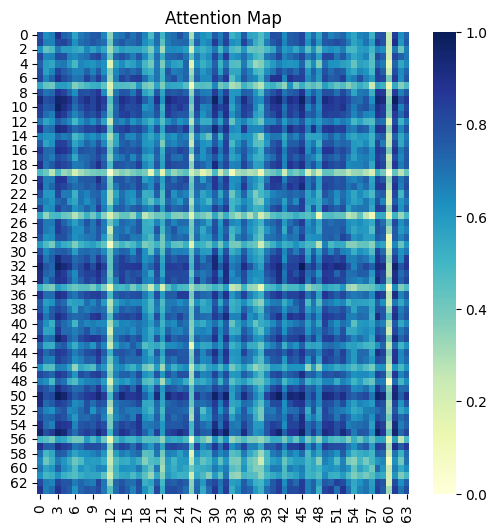

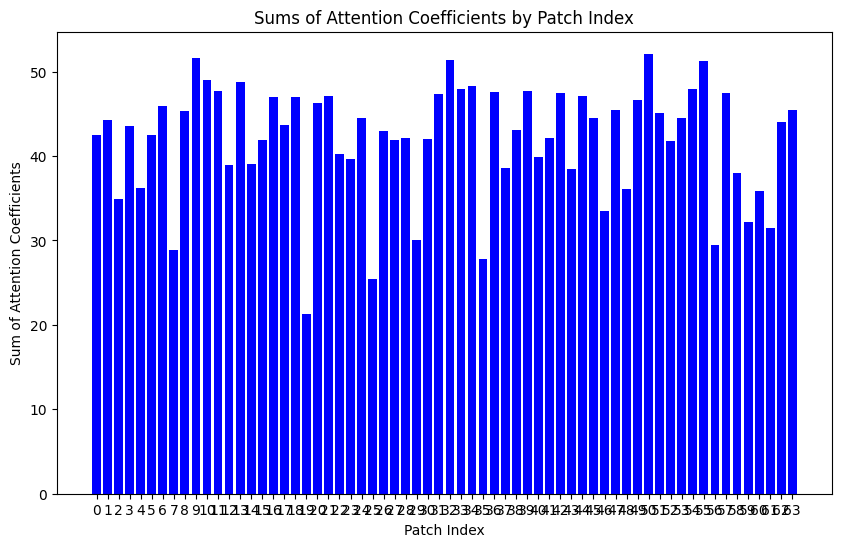

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.6938)

tensor(432.8546, grad_fn=<DivBackward1>)


 27%|██▋       | 8/30 [2:02:27<5:37:15, 919.78s/it]

Complete 7 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8174, 0.8055, 0.4936,  ..., 0.8855, 0.7475, 0.9983],
         [0.9457, 0.9526, 0.9763,  ..., 0.8928, 0.9789, 0.6606],
         [0.9179, 0.9091, 0.6264,  ..., 0.9637, 0.8635, 0.9869],
         ...,
         [0.9545, 0.9477, 0.6918,  ..., 0.9868, 0.9106, 0.9639],
         [0.9690, 0.9743, 0.9553,  ..., 0.9257, 0.9924, 0.7101],
         [0.8578, 0.8469, 0.5418,  ..., 0.9187, 0.7927, 0.9997]],

        [[0.9958, 0.9751, 0.9993,  ..., 0.8668, 0.9772, 0.9966],
         [0.9802, 0.9978, 0.9474,  ..., 0.7109, 0.9971, 0.9786],
         [0.8681, 0.9237, 0.8040,  ..., 0.5116, 0.9200, 0.8643],
         ...,
         [0.9879, 0.9997, 0.9603,  ..., 0.7366, 0.9995, 0.9866],
         [0.9118, 0.9570, 0.8556,  ..., 0.5727, 0.9542, 0.9086],
         [0.9061, 0.9529, 0.8487,  ..., 0.5640, 0.9499, 0.9027]],

        [[0.8449, 0.8622, 0.9138,  ..., 0.9201, 0.7256, 0.9981],
         [0.9969, 0.9991, 0.9971,  ..., 0.9957, 0.9560, 0.9079],
         [0.9936, 0.9890, 0.9645,  ..., 0.9601, 0.9

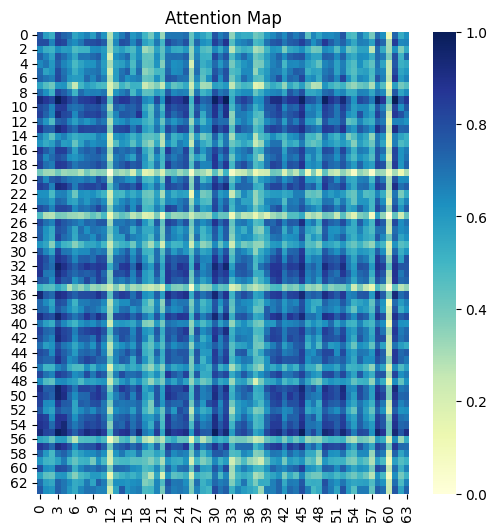

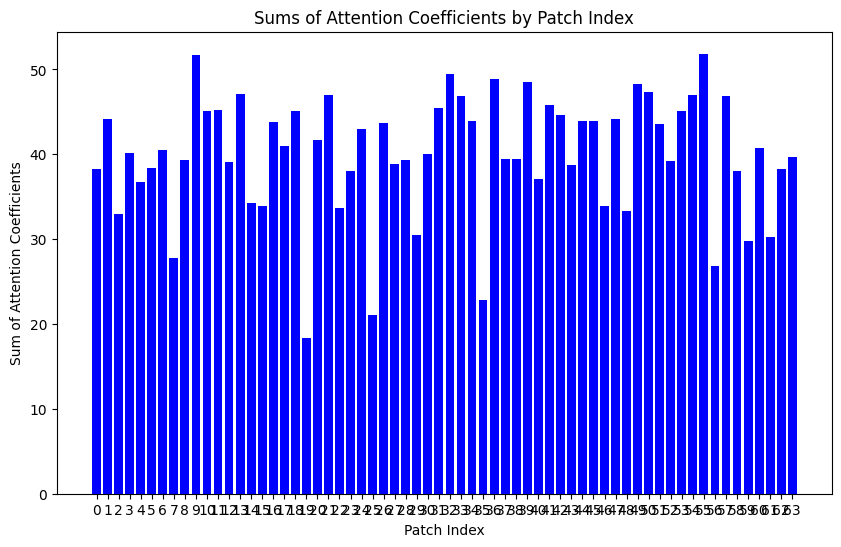

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7312)

tensor(432.1595, grad_fn=<DivBackward1>)


 30%|███       | 9/30 [2:18:47<5:28:30, 938.60s/it]

Complete 8 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.7859, 0.9959, 0.9997,  ..., 0.8361, 0.9952, 0.8883],
         [0.9900, 0.7571, 0.7192,  ..., 0.9721, 0.7619, 0.9408],
         [0.9865, 0.7442, 0.7059,  ..., 0.9666, 0.7490, 0.9331],
         ...,
         [0.9082, 0.9864, 0.9737,  ..., 0.9429, 0.9878, 0.9736],
         [0.9968, 0.8717, 0.8403,  ..., 0.9999, 0.8755, 0.9919],
         [0.9999, 0.8271, 0.7925,  ..., 0.9942, 0.8314, 0.9762]],

        [[0.9741, 0.9314, 0.9696,  ..., 0.9724, 0.7249, 0.9552],
         [0.9936, 0.9994, 0.8397,  ..., 0.9944, 0.8998, 0.9992],
         [0.9900, 0.9589, 0.9451,  ..., 0.9890, 0.7747, 0.9771],
         ...,
         [0.9989, 0.9949, 0.8714,  ..., 0.9992, 0.8709, 0.9996],
         [0.9536, 0.9872, 0.7342,  ..., 0.9557, 0.9656, 0.9728],
         [0.9590, 0.9900, 0.7450,  ..., 0.9609, 0.9607, 0.9769]],

        [[0.9966, 1.0000, 0.9318,  ..., 0.9874, 0.9335, 0.9783],
         [0.8509, 0.8863, 0.9940,  ..., 0.9481, 0.9934, 0.9625],
         [0.9489, 0.9700, 0.9910,  ..., 0.9966, 0.9

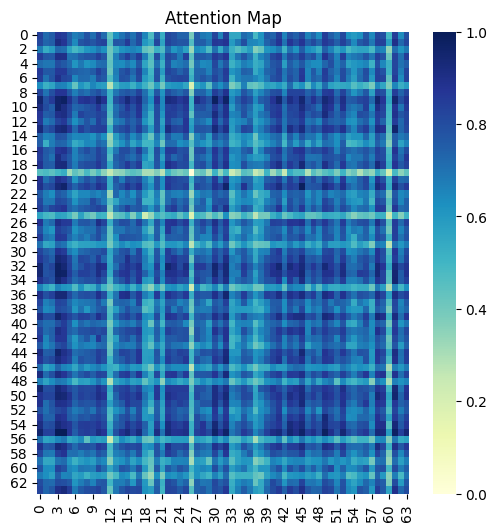

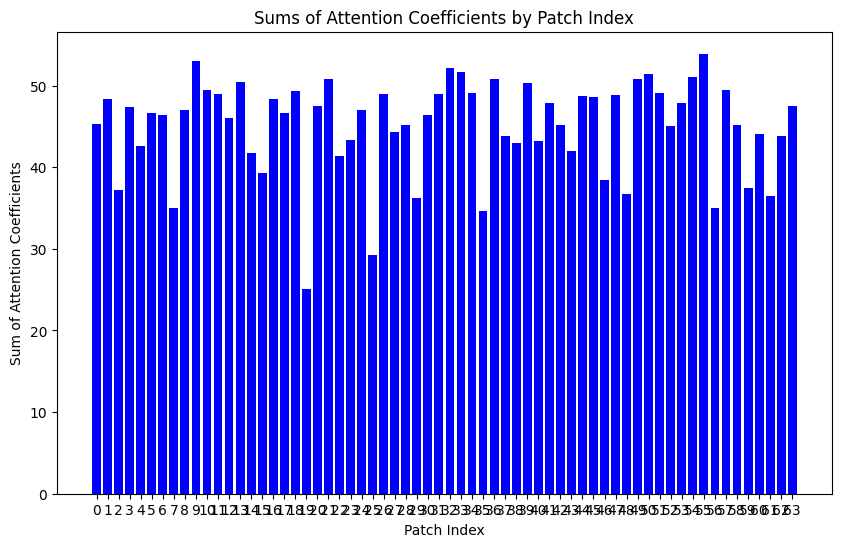

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.6875)

tensor(433.1102, grad_fn=<DivBackward1>)


 33%|███▎      | 10/30 [2:35:36<5:20:05, 960.26s/it]

Complete 9 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9997, 0.9946, 0.9578,  ..., 0.9793, 0.9756, 0.9301],
         [0.8708, 0.9057, 0.9680,  ..., 0.7530, 0.7429, 0.9860],
         [0.9266, 0.9533, 0.9929,  ..., 0.8263, 0.8172, 0.9995],
         ...,
         [0.9720, 0.9877, 0.9995,  ..., 0.8972, 0.8897, 0.9929],
         [0.9412, 0.9120, 0.8255,  ..., 0.9927, 0.9947, 0.7792],
         [0.9696, 0.9861, 0.9997,  ..., 0.8930, 0.8853, 0.9940]],

        [[0.8020, 0.9687, 0.9789,  ..., 0.9988, 0.9029, 0.9356],
         [0.9361, 0.9988, 0.8792,  ..., 0.9409, 0.9886, 0.8012],
         [0.9939, 0.8722, 0.6176,  ..., 0.7125, 0.9491, 0.5221],
         ...,
         [0.9084, 0.9997, 0.9107,  ..., 0.9631, 0.9748, 0.8398],
         [0.9822, 0.9756, 0.7929,  ..., 0.8722, 0.9997, 0.7029],
         [0.9871, 0.8485, 0.5871,  ..., 0.6827, 0.9326, 0.4923]],

        [[0.9901, 0.9261, 0.8524,  ..., 0.9957, 0.8501, 0.9972],
         [0.9745, 0.8919, 0.8087,  ..., 0.9841, 0.8062, 0.9870],
         [0.9810, 0.9985, 0.9743,  ..., 0.9705, 0.9

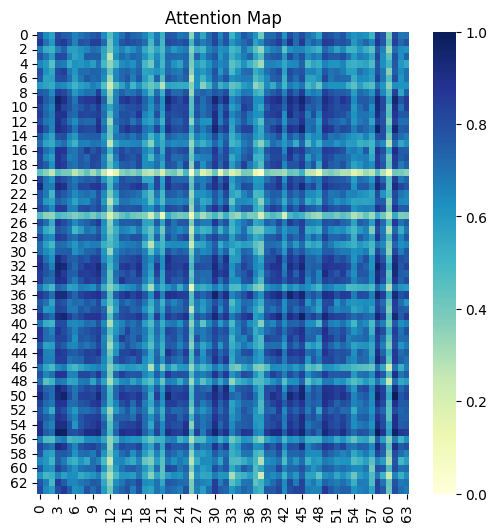

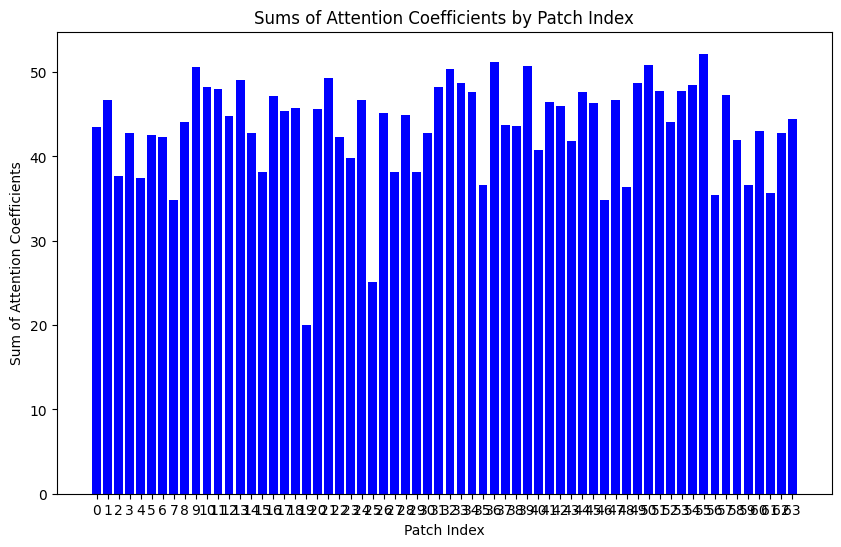

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7188)

tensor(431.5258, grad_fn=<DivBackward1>)


 37%|███▋      | 11/30 [2:51:21<5:02:35, 955.57s/it]

Complete 10 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9319, 0.9026, 0.9636,  ..., 0.8710, 0.8707, 0.9999],
         [0.8217, 0.8598, 0.7661,  ..., 0.8926, 0.8928, 0.5961],
         [0.8926, 0.9233, 0.8452,  ..., 0.9481, 0.9483, 0.6867],
         ...,
         [0.9963, 1.0000, 0.9822,  ..., 0.9980, 0.9979, 0.8927],
         [0.9637, 0.9409, 0.9859,  ..., 0.9148, 0.9146, 0.9930],
         [0.9111, 0.8786, 0.9475,  ..., 0.8444, 0.8441, 0.9992]],

        [[0.9586, 1.0000, 0.9959,  ..., 0.7720, 0.9667, 0.9927],
         [0.9790, 0.9958, 1.0000,  ..., 0.8176, 0.9423, 0.9994],
         [0.9799, 0.9953, 1.0000,  ..., 0.8199, 0.9408, 0.9995],
         ...,
         [0.8918, 0.9838, 0.9620,  ..., 0.6626, 0.9974, 0.9535],
         [0.9193, 0.7782, 0.8301,  ..., 0.9998, 0.6302, 0.8451],
         [0.9999, 0.9601, 0.9826,  ..., 0.9072, 0.8652, 0.9877]],

        [[0.7993, 0.5124, 0.5977,  ..., 0.8555, 0.9625, 0.6347],
         [0.9259, 0.9955, 0.9989,  ..., 0.8811, 0.7346, 0.9942],
         [0.8989, 0.9997, 0.9932,  ..., 0.8489, 0.6

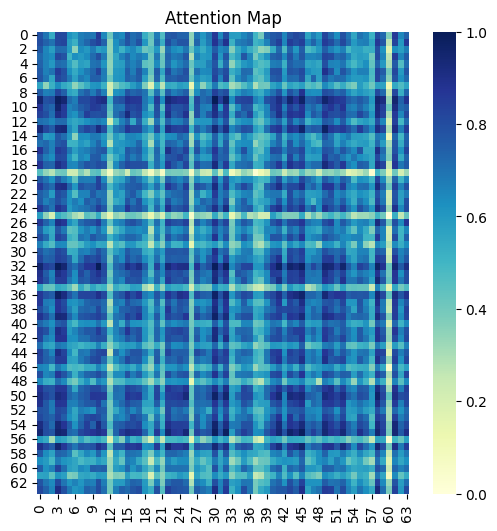

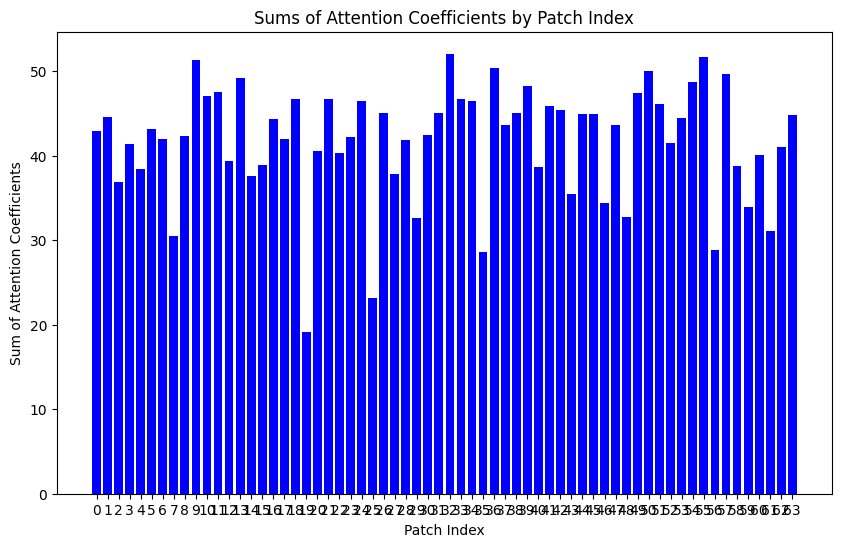

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7750)

tensor(430.0663, grad_fn=<DivBackward1>)


 40%|████      | 12/30 [3:06:41<4:43:23, 944.63s/it]

Complete 11 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8565, 0.7019, 0.9706,  ..., 0.9292, 0.7871, 0.5972],
         [0.8351, 0.6759, 0.9594,  ..., 0.9128, 0.7629, 0.5707],
         [0.9165, 0.7814, 0.9945,  ..., 0.9706, 0.8583, 0.6811],
         ...,
         [0.9032, 0.7627, 0.9904,  ..., 0.9621, 0.8419, 0.6609],
         [0.9551, 0.8413, 1.0000,  ..., 0.9916, 0.9084, 0.7481],
         [0.8947, 0.9827, 0.7354,  ..., 0.8122, 0.9450, 0.9999]],

        [[0.8702, 0.9931, 0.9657,  ..., 0.9981, 0.8778, 0.9709],
         [0.9833, 0.8389, 0.9051,  ..., 0.7417, 0.4744, 0.8964],
         [0.9999, 0.9246, 0.9693,  ..., 0.8469, 0.5916, 0.9639],
         ...,
         [0.8801, 0.9954, 0.9711,  ..., 0.9964, 0.8677, 0.9759],
         [0.7882, 0.9615, 0.9130,  ..., 0.9950, 0.9412, 0.9211],
         [0.9934, 0.8716, 0.9311,  ..., 0.7802, 0.5145, 0.9234]],

        [[0.9693, 0.8908, 0.9330,  ..., 0.9220, 0.9385, 0.9696],
         [0.9705, 0.9999, 0.9926,  ..., 0.9958, 0.9905, 0.9702],
         [0.8382, 0.9363, 0.8948,  ..., 0.9074, 0.8

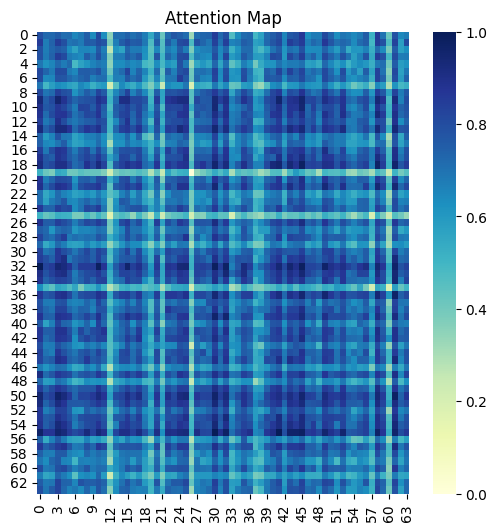

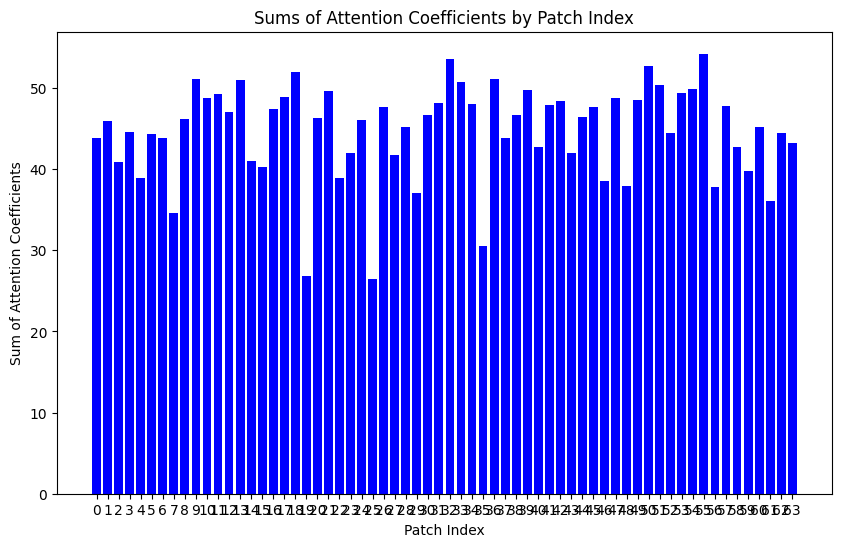

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7563)

tensor(430.6303, grad_fn=<DivBackward1>)


 43%|████▎     | 13/30 [3:22:16<4:26:51, 941.86s/it]

Complete 12 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9086, 0.9825, 0.9404,  ..., 0.9930, 0.9989, 0.9976],
         [0.6999, 0.8379, 0.7505,  ..., 0.8712, 0.9017, 0.8925],
         [0.9945, 0.9390, 0.9818,  ..., 0.9139, 0.8849, 0.8944],
         ...,
         [0.8614, 0.9571, 0.9000,  ..., 0.9747, 0.9879, 0.9842],
         [0.8761, 0.9656, 0.9128,  ..., 0.9812, 0.9923, 0.9893],
         [0.9726, 0.9999, 0.9890,  ..., 0.9965, 0.9882, 0.9913]],

        [[0.9540, 0.9766, 0.9988,  ..., 0.9678, 0.9867, 0.8652],
         [0.9990, 0.8908, 0.9526,  ..., 1.0000, 0.9130, 0.9629],
         [0.9837, 0.9427, 0.9849,  ..., 0.9916, 0.9590, 0.9185],
         ...,
         [0.9756, 0.7566, 0.8463,  ..., 0.9633, 0.7866, 1.0000],
         [0.8781, 0.5857, 0.6877,  ..., 0.8544, 0.6184, 0.9619],
         [0.9992, 0.8529, 0.9249,  ..., 0.9959, 0.8780, 0.9818]],

        [[0.9693, 0.9558, 0.9895,  ..., 0.9535, 0.7874, 0.9963],
         [0.9970, 0.8941, 0.9996,  ..., 0.8907, 0.6885, 0.9963],
         [0.8017, 0.9934, 0.8545,  ..., 0.9943, 0.9

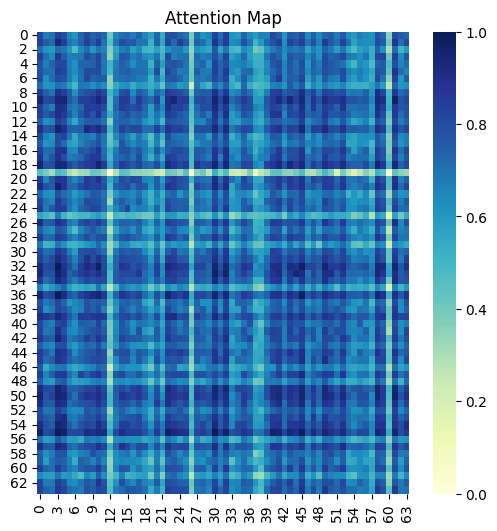

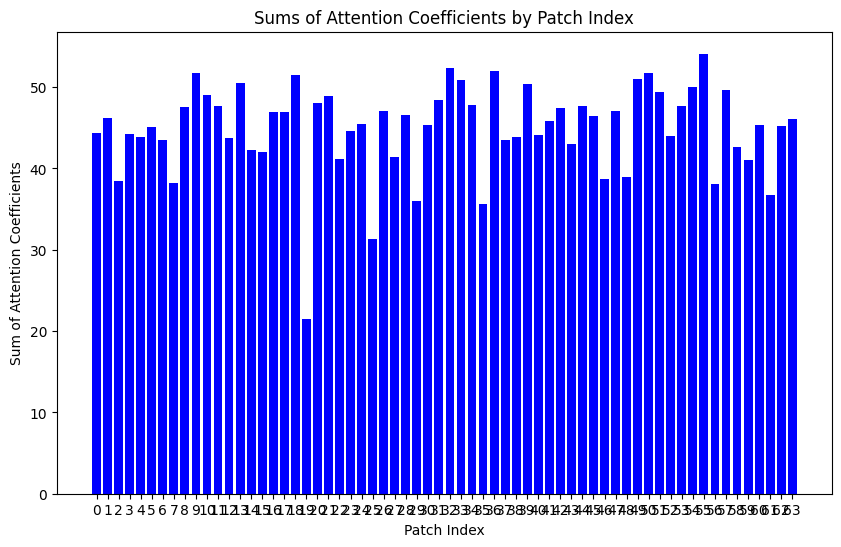

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7688)

tensor(430.2420, grad_fn=<DivBackward1>)


 47%|████▋     | 14/30 [3:37:44<4:09:59, 937.50s/it]

Complete 13 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9980, 0.6404, 0.9997,  ..., 0.8540, 0.8163, 0.9919],
         [0.9776, 0.7288, 0.9925,  ..., 0.9182, 0.8875, 0.9998],
         [0.9460, 0.7963, 0.9708,  ..., 0.9581, 0.9345, 0.9900],
         ...,
         [0.9360, 0.8125, 0.9633,  ..., 0.9662, 0.9446, 0.9853],
         [0.7923, 0.9483, 0.8391,  ..., 0.9984, 0.9998, 0.8866],
         [0.9975, 0.6449, 0.9998,  ..., 0.8576, 0.8201, 0.9928]],

        [[0.9683, 0.9873, 0.9755,  ..., 0.9938, 0.8484, 0.8881],
         [0.9925, 0.9996, 0.9958,  ..., 0.9711, 0.9067, 0.9385],
         [0.9791, 0.9562, 0.9725,  ..., 0.8499, 0.9935, 0.9996],
         ...,
         [0.9518, 0.9199, 0.9422,  ..., 0.7939, 1.0000, 0.9967],
         [0.9992, 0.9912, 0.9976,  ..., 0.9218, 0.9613, 0.9812],
         [0.9730, 0.9903, 0.9796,  ..., 0.9915, 0.8578, 0.8965]],

        [[0.9780, 0.9604, 0.4168,  ..., 0.7972, 0.9746, 0.9949],
         [0.9991, 0.9934, 0.5141,  ..., 0.8807, 0.9983, 0.9977],
         [0.9674, 0.9467, 0.3916,  ..., 0.7718, 0.9

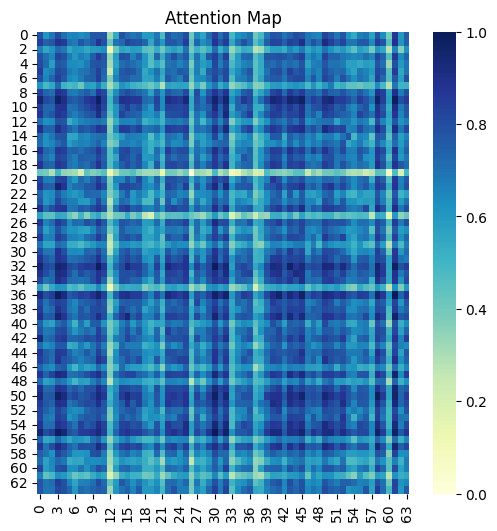

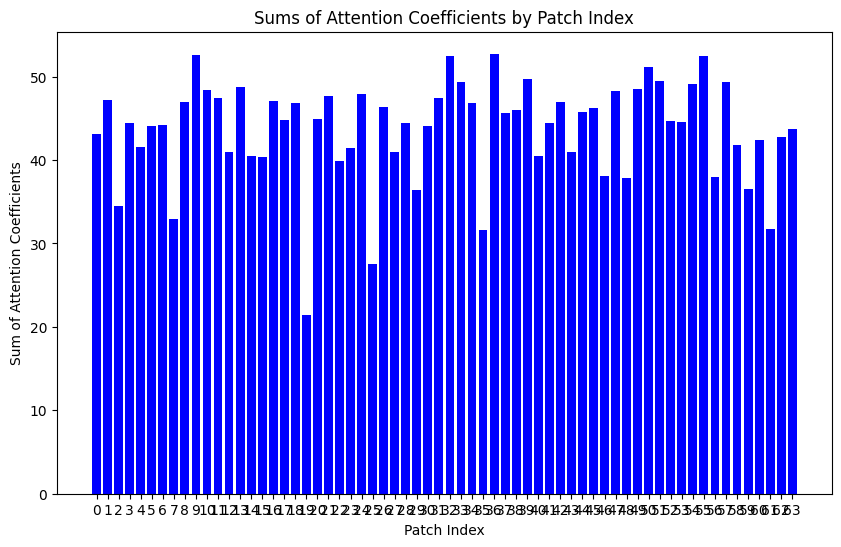

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8062)

tensor(428.6457, grad_fn=<DivBackward1>)


 50%|█████     | 15/30 [3:53:26<3:54:46, 939.09s/it]

Complete 14 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.7843, 0.9172, 0.7741,  ..., 0.7173, 0.5368, 0.9868],
         [0.9342, 0.8095, 0.9405,  ..., 0.9691, 0.9988, 0.6652],
         [0.8712, 0.7224, 0.8796,  ..., 0.9205, 0.9943, 0.5706],
         ...,
         [0.9237, 0.9932, 0.9167,  ..., 0.8751, 0.7163, 0.9908],
         [0.9879, 0.9922, 0.9848,  ..., 0.9630, 0.8477, 0.9311],
         [0.9998, 0.9559, 1.0000,  ..., 0.9951, 0.9233, 0.8581]],

        [[0.9444, 0.9943, 0.9978,  ..., 0.9545, 0.9993, 0.9168],
         [0.9799, 0.9995, 0.9796,  ..., 0.9859, 0.9851, 0.9615],
         [0.9982, 0.9583, 0.8977,  ..., 0.9957, 0.9098, 0.9998],
         ...,
         [0.9981, 0.9856, 0.9428,  ..., 0.9996, 0.9521, 0.9903],
         [0.9901, 0.9328, 0.8616,  ..., 0.9849, 0.8754, 0.9980],
         [0.9016, 0.9753, 0.9987,  ..., 0.9147, 0.9968, 0.8672]],

        [[0.7479, 0.8233, 0.9055,  ..., 0.9160, 0.8993, 0.4904],
         [0.9758, 0.9372, 0.8653,  ..., 0.8526, 0.8722, 0.9782],
         [0.9815, 0.9985, 0.9924,  ..., 0.9888, 0.9

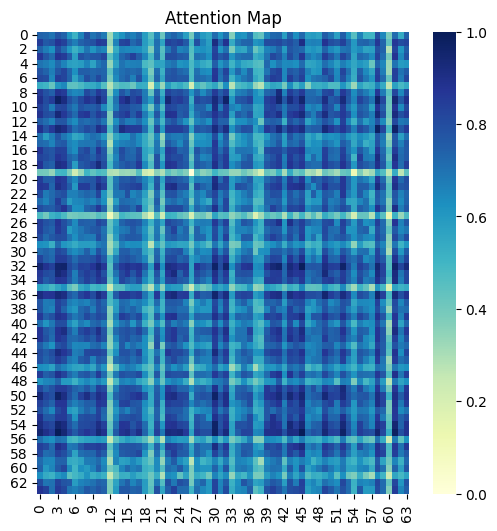

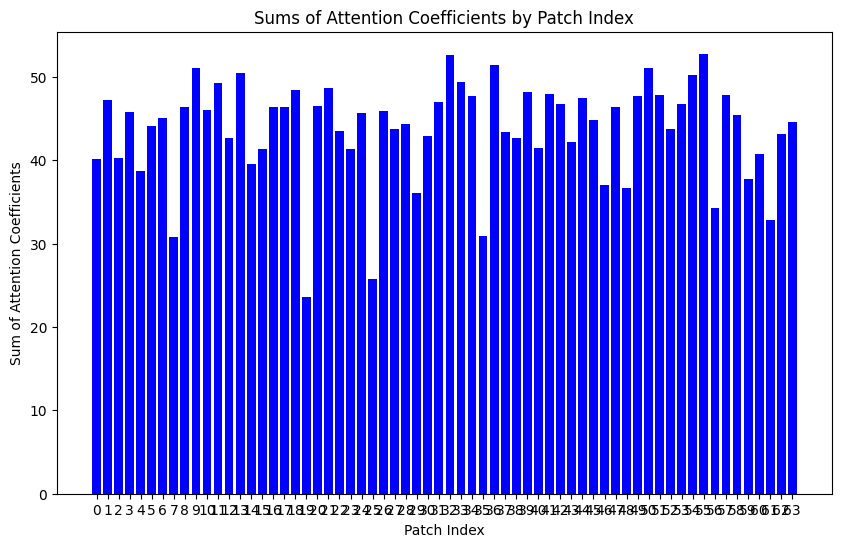

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8000)

tensor(428.8001, grad_fn=<DivBackward1>)


 53%|█████▎    | 16/30 [4:08:55<3:38:22, 935.89s/it]

Complete 15 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8292, 0.9684, 0.9873,  ..., 0.7852, 0.9785, 0.9663],
         [0.9526, 0.9989, 0.9902,  ..., 0.9250, 0.9958, 0.9993],
         [0.9968, 0.9621, 0.9333,  ..., 0.9867, 0.9492, 0.9643],
         ...,
         [0.9174, 0.7413, 0.6866,  ..., 0.9464, 0.7152, 0.7461],
         [0.9906, 0.8842, 0.8405,  ..., 0.9985, 0.8638, 0.8879],
         [0.8672, 0.9848, 0.9967,  ..., 0.8266, 0.9915, 0.9833]],

        [[0.7559, 0.6179, 0.5839,  ..., 0.7863, 0.9106, 0.9458],
         [0.9636, 0.8801, 0.8541,  ..., 0.9766, 0.9991, 0.9900],
         [0.8516, 0.7262, 0.6932,  ..., 0.8771, 0.9689, 0.9884],
         ...,
         [0.9622, 0.8777, 0.8515,  ..., 0.9754, 0.9993, 0.9907],
         [0.9356, 0.8363, 0.8074,  ..., 0.9530, 0.9988, 0.9988],
         [0.9936, 0.9928, 0.9846,  ..., 0.9860, 0.9123, 0.8702]],

        [[0.8656, 0.8528, 0.9241,  ..., 0.7939, 0.9676, 0.8989],
         [0.9806, 0.9750, 0.9983,  ..., 0.9437, 0.9966, 0.9925],
         [0.9900, 0.9859, 1.0000,  ..., 0.9605, 0.9

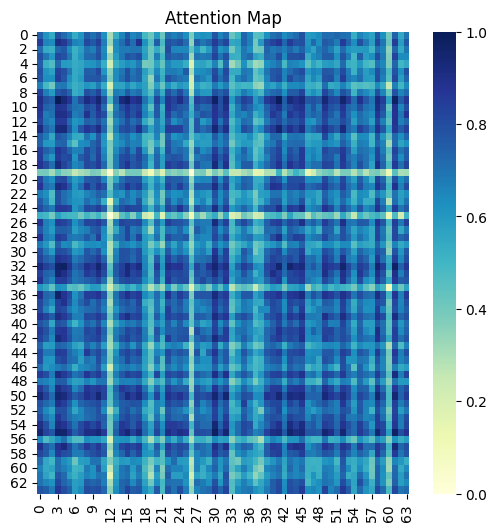

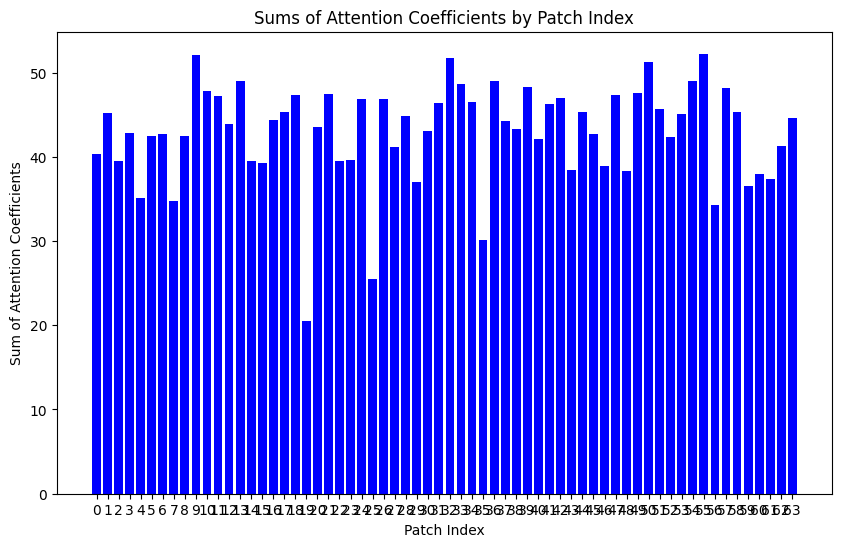

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7937)

tensor(428.9655, grad_fn=<DivBackward1>)


 57%|█████▋    | 17/30 [4:24:21<3:22:10, 933.12s/it]

Complete 16 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9775, 0.8235, 0.8981,  ..., 0.9798, 0.9047, 0.9917],
         [0.8660, 0.9559, 0.9902,  ..., 0.9927, 0.9923, 0.9031],
         [0.9898, 0.6185, 0.7142,  ..., 0.8552, 0.7235, 0.9743],
         ...,
         [0.5742, 0.9768, 0.9317,  ..., 0.8161, 0.9260, 0.6257],
         [0.9960, 0.7567, 0.8417,  ..., 0.9483, 0.8496, 1.0000],
         [0.8950, 0.9352, 0.9790,  ..., 0.9985, 0.9821, 0.9282]],

        [[0.9983, 0.9769, 0.8927,  ..., 0.7705, 0.9984, 0.9012],
         [0.8449, 0.9544, 0.9990,  ..., 0.9801, 0.8975, 0.9978],
         [0.6802, 0.8338, 0.9429,  ..., 0.9953, 0.7478, 0.9362],
         ...,
         [0.7185, 0.8652, 0.9621,  ..., 0.9995, 0.7841, 0.9565],
         [0.9947, 0.9853, 0.9108,  ..., 0.7947, 0.9999, 0.9187],
         [0.8210, 0.9396, 0.9957,  ..., 0.9884, 0.8770, 0.9936]],

        [[0.9755, 0.9971, 0.9988,  ..., 0.9709, 0.8306, 0.9500],
         [0.9989, 0.9421, 0.9759,  ..., 0.8770, 0.6797, 0.9987],
         [0.9955, 0.9254, 0.9645,  ..., 0.8545, 0.6

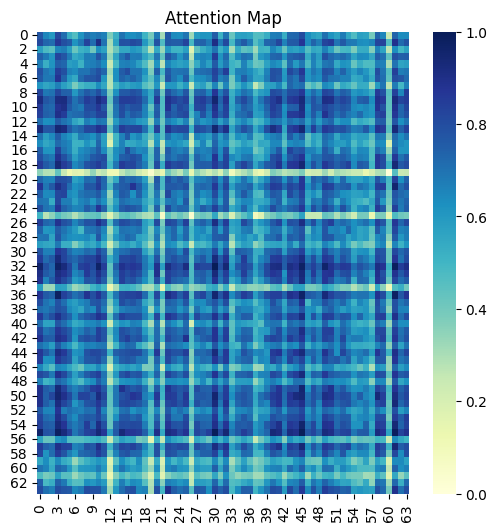

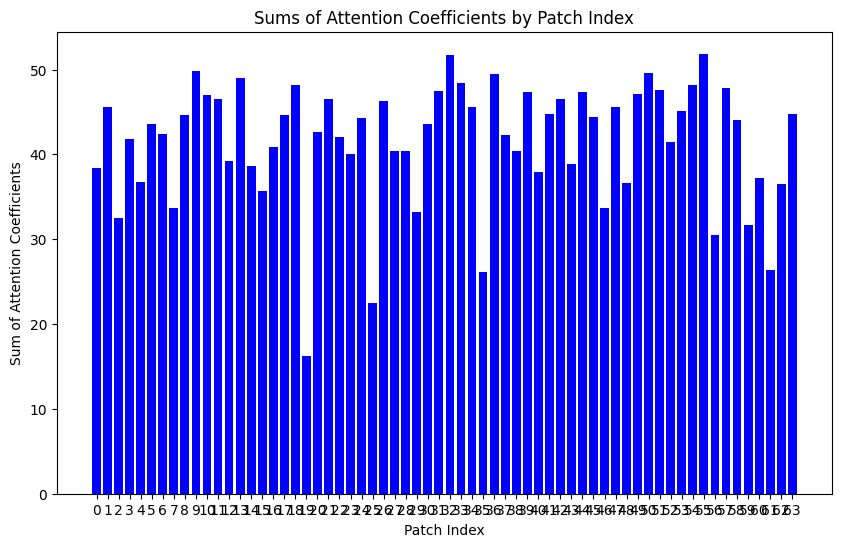

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8000)

tensor(427.8477, grad_fn=<DivBackward1>)


 60%|██████    | 18/30 [4:40:45<3:09:39, 948.29s/it]

Complete 17 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9266, 0.9993, 0.9997,  ..., 0.9921, 0.9856, 0.9295],
         [0.6766, 0.8685, 0.8747,  ..., 0.8254, 0.8024, 0.9939],
         [0.9999, 0.9445, 0.9401,  ..., 0.9694, 0.9791, 0.7502],
         ...,
         [0.7875, 0.9444, 0.9486,  ..., 0.9129, 0.8950, 0.9967],
         [0.9902, 0.8854, 0.8795,  ..., 0.9214, 0.9370, 0.6589],
         [0.9397, 1.0000, 0.9999,  ..., 0.9961, 0.9913, 0.9155]],

        [[0.9993, 0.8664, 0.9507,  ..., 1.0000, 0.9996, 0.9860],
         [0.9972, 0.9138, 0.9788,  ..., 0.9945, 0.9965, 0.9984],
         [0.8795, 1.0000, 0.9749,  ..., 0.8654, 0.8753, 0.9320],
         ...,
         [0.9860, 0.9466, 0.9936,  ..., 0.9805, 0.9844, 0.9993],
         [0.9476, 0.9855, 0.9989,  ..., 0.9376, 0.9446, 0.9808],
         [0.9971, 0.8474, 0.9380,  ..., 0.9990, 0.9978, 0.9786]],

        [[0.9960, 0.9484, 0.9775,  ..., 0.9916, 0.9790, 0.9584],
         [0.9115, 0.8009, 0.9919,  ..., 0.9781, 0.9910, 0.9988],
         [0.9748, 0.8989, 0.9970,  ..., 1.0000, 0.9

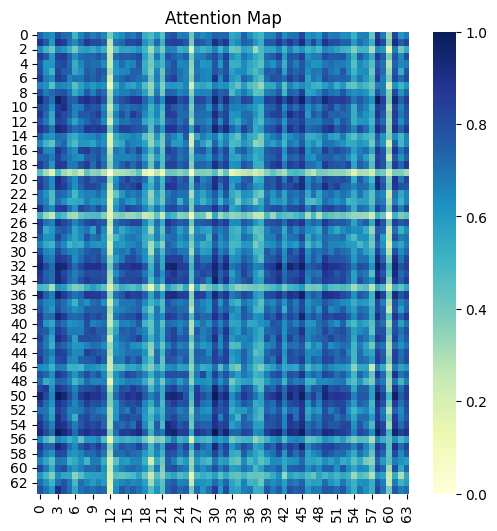

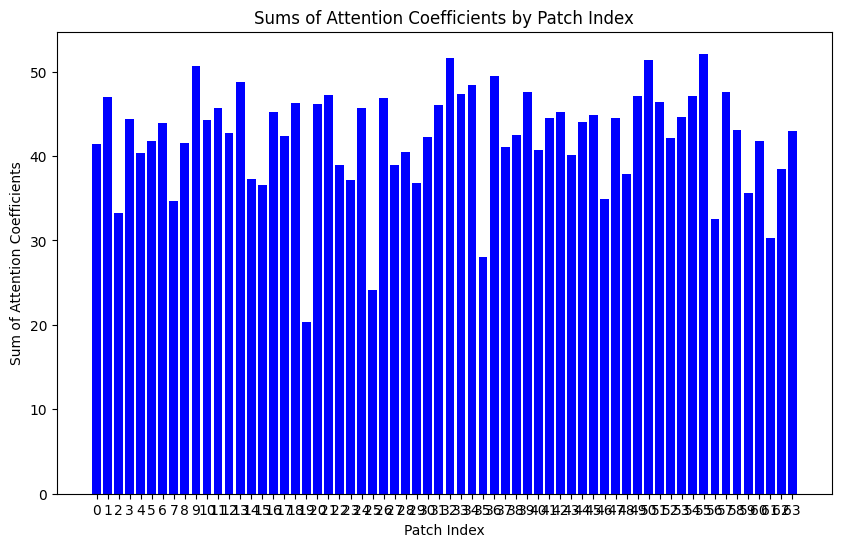

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8313)

tensor(427.4517, grad_fn=<DivBackward1>)


 63%|██████▎   | 19/30 [4:57:38<2:57:24, 967.67s/it]

Complete 18 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9888, 0.8712, 0.9992,  ..., 0.9995, 0.9917, 0.9714],
         [0.9121, 0.9985, 0.8652,  ..., 0.8609, 0.7783, 0.9444],
         [0.9910, 0.9715, 0.9707,  ..., 0.9685, 0.9180, 0.9990],
         ...,
         [0.7472, 0.9273, 0.6834,  ..., 0.6779, 0.5808, 0.7975],
         [0.9370, 0.9999, 0.8954,  ..., 0.8916, 0.8149, 0.9642],
         [0.9131, 0.7254, 0.9509,  ..., 0.9537, 0.9892, 0.8749]],

        [[0.9729, 0.8885, 0.9593,  ..., 0.8837, 0.8449, 0.9947],
         [0.9761, 0.9995, 0.9863,  ..., 0.9991, 0.5855, 0.8562],
         [0.9443, 0.9963, 0.9603,  ..., 0.9971, 0.5141, 0.7957],
         ...,
         [0.9664, 1.0000, 0.9787,  ..., 1.0000, 0.5604, 0.8359],
         [0.9518, 0.8519, 0.9345,  ..., 0.8465, 0.8822, 0.9997],
         [0.7720, 0.6240, 0.7416,  ..., 0.6172, 0.9954, 0.9297]],

        [[0.9892, 0.8620, 0.9069,  ..., 0.9691, 0.9922, 0.9833],
         [0.9328, 0.9997, 0.9969,  ..., 0.9644, 0.9248, 0.7807],
         [0.7882, 0.9582, 0.9249,  ..., 0.8421, 0.7

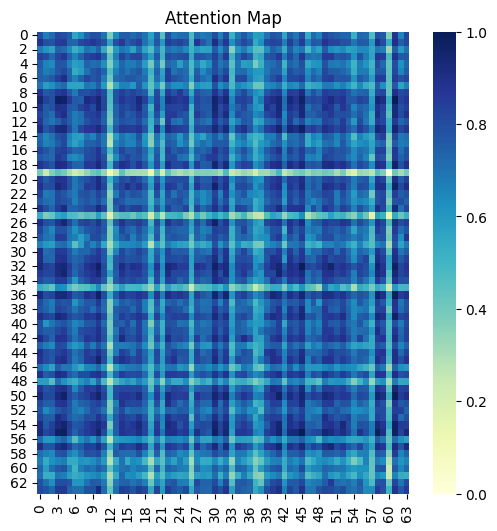

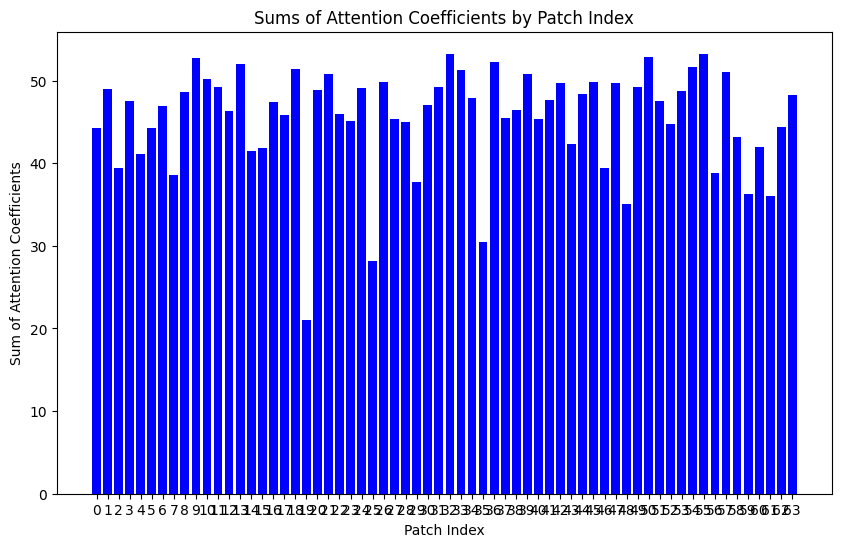

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8000)

tensor(427.7782, grad_fn=<DivBackward1>)


 67%|██████▋   | 20/30 [5:13:14<2:39:42, 958.28s/it]

Complete 19 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9151, 0.8700, 0.8374,  ..., 0.8231, 0.7836, 0.8372],
         [0.9234, 0.9581, 0.9750,  ..., 0.9809, 0.9926, 0.9751],
         [0.9996, 0.9912, 0.9800,  ..., 0.9741, 0.9549, 0.9799],
         ...,
         [0.9784, 0.9515, 0.9292,  ..., 0.9188, 0.8887, 0.9290],
         [0.8783, 0.9221, 0.9454,  ..., 0.9540, 0.9734, 0.9456],
         [0.9545, 0.9187, 0.8914,  ..., 0.8790, 0.8441, 0.8911]],

        [[0.9583, 0.9936, 0.9999,  ..., 0.9991, 0.9997, 0.9928],
         [1.0000, 0.9826, 0.9528,  ..., 0.9669, 0.9479, 0.9151],
         [0.9084, 0.9668, 0.9908,  ..., 0.9826, 0.9928, 0.9997],
         ...,
         [0.9484, 0.8807, 0.8213,  ..., 0.8471, 0.8130, 0.7618],
         [0.9709, 0.9149, 0.8619,  ..., 0.8852, 0.8542, 0.8067],
         [0.9946, 0.9607, 0.9207,  ..., 0.9389, 0.9146, 0.8750]],

        [[0.9032, 0.9866, 0.9953,  ..., 0.9419, 0.9981, 0.9906],
         [0.9957, 0.7779, 0.8138,  ..., 0.9805, 0.8319, 0.7924],
         [0.8925, 0.9904, 0.9974,  ..., 0.9332, 0.9

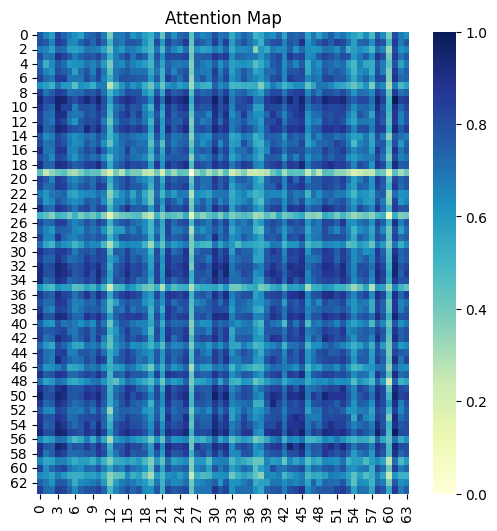

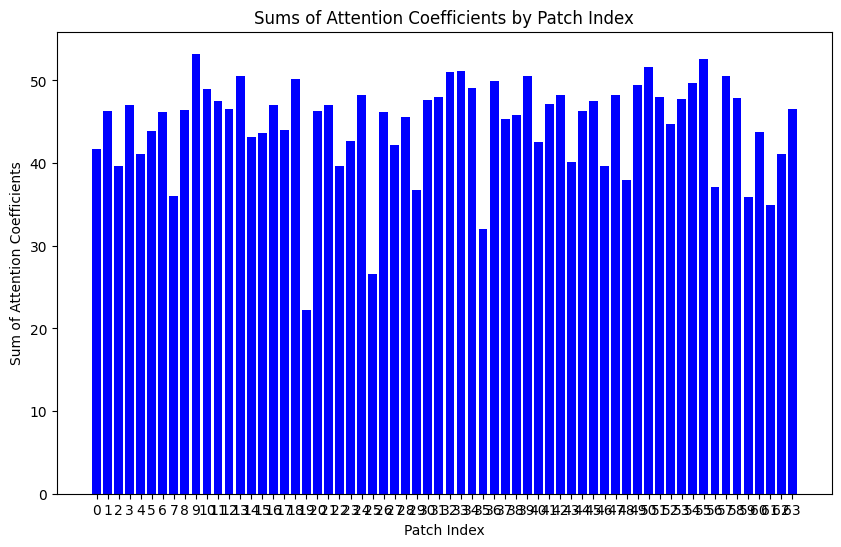

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8062)

tensor(427.4190, grad_fn=<DivBackward1>)


 70%|███████   | 21/30 [5:28:53<2:22:51, 952.39s/it]

Complete 20 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.7056, 0.8235, 0.4200,  ..., 0.7044, 0.9980, 0.8352],
         [0.8531, 0.9400, 0.5787,  ..., 0.8521, 0.9457, 0.9474],
         [0.8112, 0.9098, 0.5287,  ..., 0.8102, 0.9690, 0.9187],
         ...,
         [0.5761, 0.7038, 0.3091,  ..., 0.5749, 0.9885, 0.7173],
         [1.0000, 0.9780, 0.8899,  ..., 1.0000, 0.6689, 0.9730],
         [0.9836, 0.9253, 0.9560,  ..., 0.9839, 0.5582, 0.9167]],

        [[0.9556, 0.5338, 0.4684,  ..., 0.4808, 0.6995, 0.8380],
         [0.9815, 0.5990, 0.5320,  ..., 0.5448, 0.7620, 0.8884],
         [0.7884, 0.9916, 0.9715,  ..., 0.9763, 0.9895, 0.9244],
         ...,
         [0.9074, 0.9310, 0.8872,  ..., 0.8963, 0.9947, 0.9891],
         [0.8670, 0.9603, 0.9246,  ..., 0.9323, 1.0000, 0.9713],
         [0.8589, 0.9648, 0.9308,  ..., 0.9382, 1.0000, 0.9672]],

        [[0.9984, 0.8326, 0.9328,  ..., 0.9232, 0.9779, 0.9919],
         [0.9112, 0.9738, 1.0000,  ..., 0.9997, 0.8423, 0.9698],
         [0.9504, 0.9429, 0.9939,  ..., 0.9906, 0.8

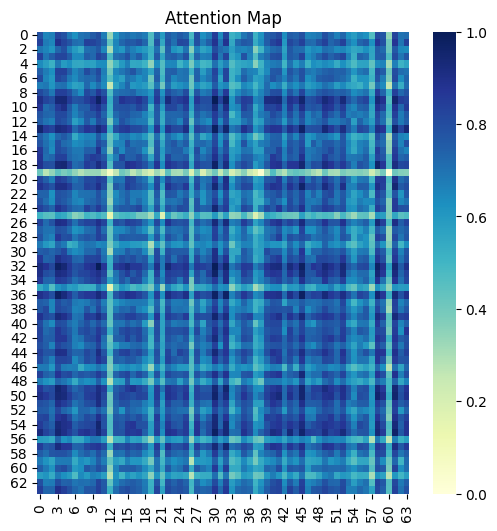

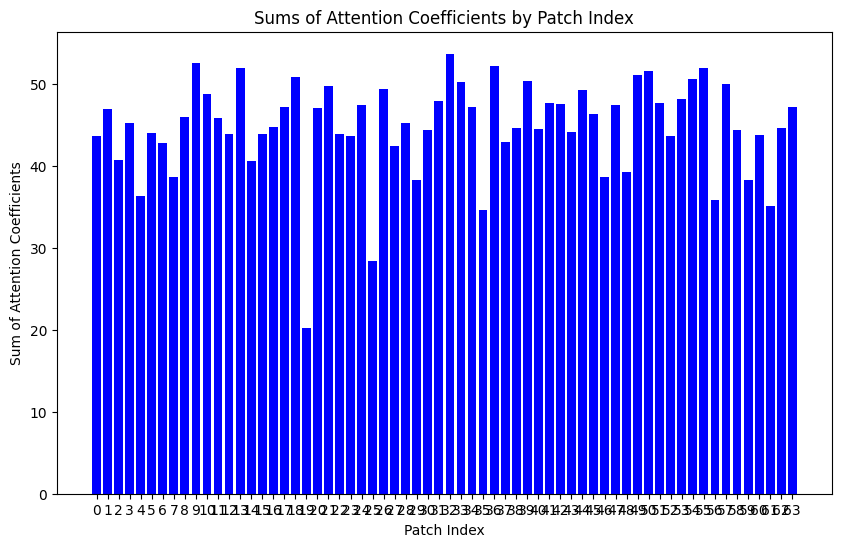

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8313)

tensor(426.8033, grad_fn=<DivBackward1>)


 73%|███████▎  | 22/30 [5:44:24<2:06:07, 945.90s/it]

Complete 21 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8716, 0.8701, 0.9813,  ..., 0.9210, 0.9989, 0.9962],
         [0.9306, 0.9294, 0.9988,  ..., 0.9666, 0.9951, 0.9734],
         [0.8353, 0.8336, 0.9642,  ..., 0.8906, 0.9926, 0.9999],
         ...,
         [0.9986, 0.9985, 0.9621,  ..., 0.9978, 0.9132, 0.8553],
         [0.9768, 0.9775, 0.8611,  ..., 0.9453, 0.7853, 0.7097],
         [0.9558, 0.9568, 0.8196,  ..., 0.9158, 0.7383, 0.6598]],

        [[0.9046, 0.9557, 0.8772,  ..., 0.9729, 0.9994, 0.9321],
         [0.8424, 0.9082, 0.8097,  ..., 0.9953, 0.9854, 0.8769],
         [0.8974, 0.9505, 0.8692,  ..., 0.9767, 0.9987, 0.9259],
         ...,
         [0.9635, 0.9157, 0.9784,  ..., 0.6337, 0.7897, 0.9419],
         [0.9985, 0.9798, 1.0000,  ..., 0.7618, 0.8956, 0.9918],
         [0.9440, 0.8885, 0.9628,  ..., 0.5933, 0.7527, 0.9185]],

        [[0.7790, 0.6236, 0.6845,  ..., 0.8474, 0.8659, 0.7947],
         [0.9702, 0.9998, 0.9966,  ..., 0.9313, 0.9170, 0.9629],
         [0.8894, 0.7553, 0.8106,  ..., 0.9396, 0.9

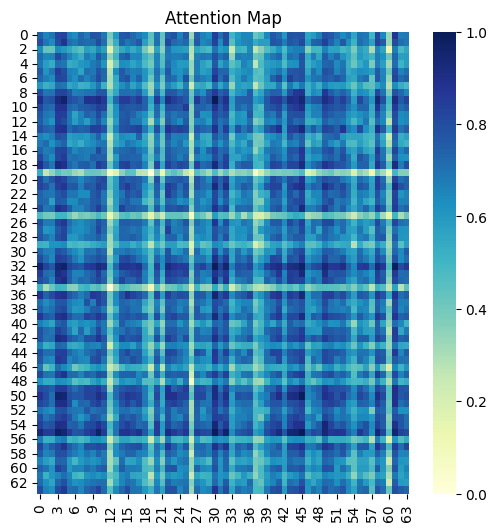

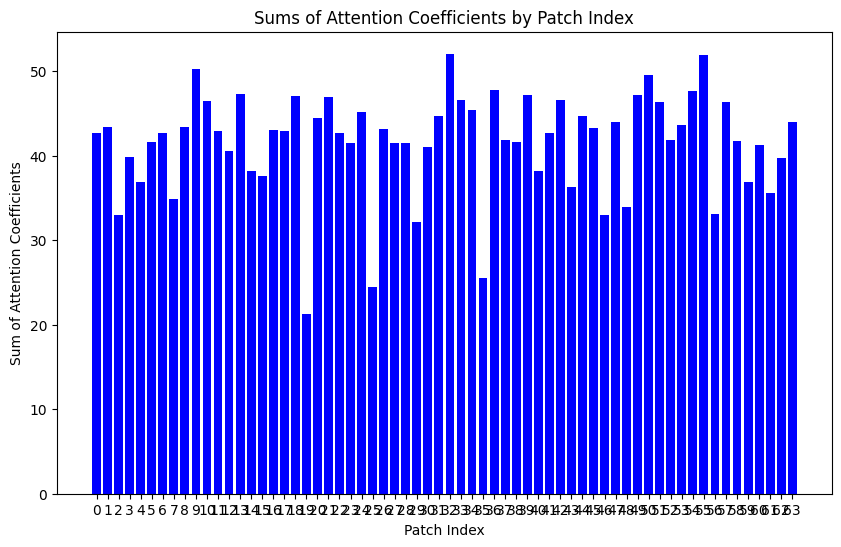

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7937)

tensor(427.0692, grad_fn=<DivBackward1>)


 77%|███████▋  | 23/30 [5:59:52<1:49:43, 940.50s/it]

Complete 22 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9746, 0.9698, 1.0000,  ..., 0.9643, 0.7670, 0.9451],
         [0.9259, 0.9332, 0.8293,  ..., 0.9407, 0.9941, 0.6334],
         [0.8793, 0.8700, 0.9595,  ..., 0.8597, 0.6014, 0.9984],
         ...,
         [0.9302, 0.9228, 0.9871,  ..., 0.9145, 0.6780, 0.9834],
         [0.9608, 0.9662, 0.8814,  ..., 0.9715, 0.9764, 0.6991],
         [0.9992, 0.9998, 0.9669,  ..., 1.0000, 0.8991, 0.8336]],

        [[0.8513, 0.7386, 0.8804,  ..., 0.9277, 0.8577, 0.7952],
         [0.9998, 0.9822, 0.9965,  ..., 0.9799, 0.9994, 0.9961],
         [0.9464, 0.8630, 0.9644,  ..., 0.9885, 0.9505, 0.9072],
         ...,
         [0.9911, 0.9970, 0.9808,  ..., 0.9519, 0.9892, 0.9997],
         [0.9759, 0.9110, 0.9876,  ..., 0.9992, 0.9787, 0.9469],
         [0.9538, 0.8742, 0.9705,  ..., 0.9919, 0.9577, 0.9167]],

        [[0.9554, 0.9634, 0.9969,  ..., 0.9679, 0.9911, 0.9945],
         [0.6864, 0.7037, 0.8123,  ..., 0.9531, 0.7834, 0.7986],
         [0.7862, 0.8019, 0.8951,  ..., 0.9908, 0.8

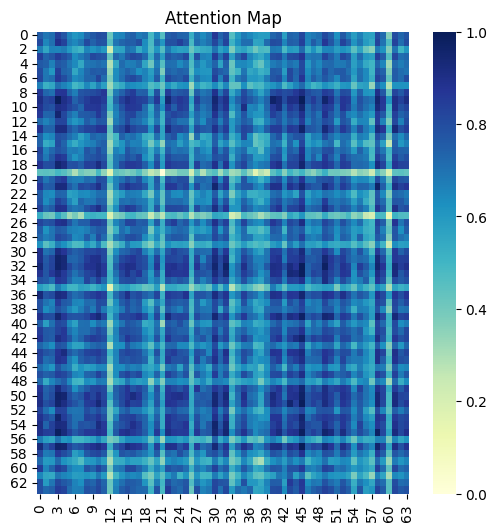

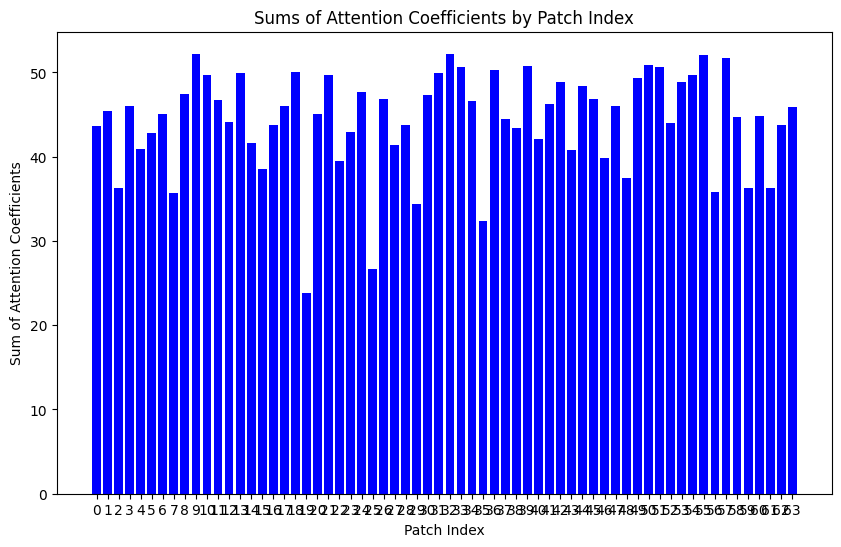

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8000)

tensor(426.9149, grad_fn=<DivBackward1>)


 80%|████████  | 24/30 [6:16:44<1:36:12, 962.13s/it]

Complete 23 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9807, 0.9563, 0.6985,  ..., 0.9985, 0.9902, 0.9991],
         [0.8474, 0.8939, 0.9972,  ..., 0.7729, 0.8187, 0.7174],
         [0.8890, 0.8418, 0.5251,  ..., 0.9429, 0.9125, 0.9703],
         ...,
         [0.7551, 0.6960, 0.3756,  ..., 0.8317, 0.7869, 0.8781],
         [0.9523, 0.9780, 0.9447,  ..., 0.9017, 0.9339, 0.8587],
         [0.9088, 0.8647, 0.5537,  ..., 0.9574, 0.9303, 0.9806]],

        [[0.9318, 0.8248, 0.8723,  ..., 0.9744, 0.9979, 0.9289],
         [0.9393, 0.8360, 0.8822,  ..., 0.9791, 0.9962, 0.9366],
         [0.9926, 0.9925, 0.9997,  ..., 0.9643, 0.8536, 0.9936],
         ...,
         [0.8251, 0.6879, 0.7451,  ..., 0.8946, 0.9841, 0.8208],
         [0.8359, 0.7006, 0.7573,  ..., 0.9034, 0.9876, 0.8317],
         [0.7454, 0.5996, 0.6589,  ..., 0.8259, 0.9483, 0.7407]],

        [[0.8979, 0.8018, 0.9501,  ..., 0.8902, 0.8540, 0.9513],
         [0.9983, 0.9900, 0.9797,  ..., 0.9992, 0.9992, 0.9789],
         [0.7592, 0.6413, 0.8362,  ..., 0.7489, 0.7

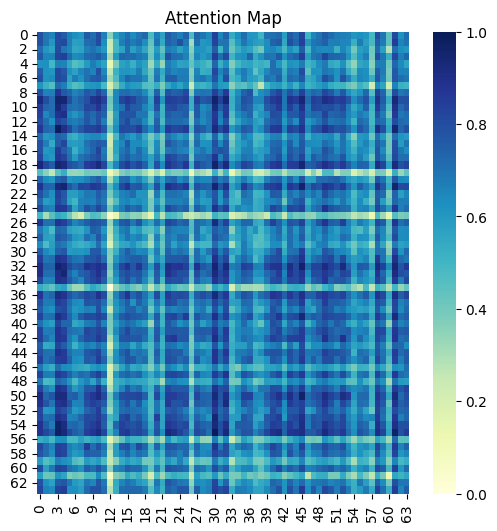

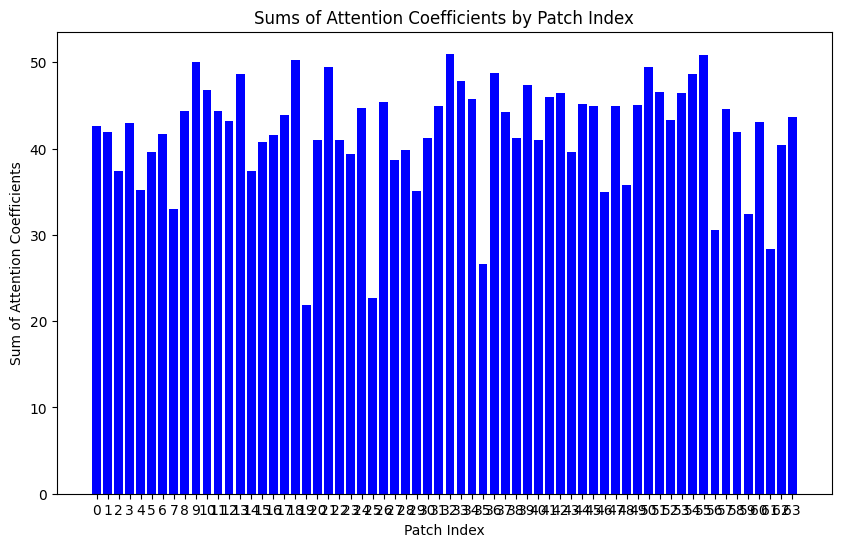

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8375)

tensor(426.1733, grad_fn=<DivBackward1>)


 83%|████████▎ | 25/30 [6:33:33<1:21:19, 976.00s/it]

Complete 24 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8540, 0.9917, 0.9994,  ..., 0.9780, 0.9792, 0.9940],
         [0.5419, 0.7966, 0.8456,  ..., 0.9458, 0.7547, 0.9098],
         [1.0000, 0.9079, 0.8667,  ..., 0.7376, 0.9359, 0.7940],
         ...,
         [0.6582, 0.8903, 0.9279,  ..., 0.9900, 0.8559, 0.9710],
         [0.4836, 0.7418, 0.7949,  ..., 0.9107, 0.6976, 0.8674],
         [0.9157, 0.9999, 0.9942,  ..., 0.9395, 0.9980, 0.9687]],

        [[0.9984, 0.9875, 0.9614,  ..., 0.9992, 0.8612, 0.9947],
         [0.9136, 0.8700, 0.8098,  ..., 0.9199, 0.6575, 0.9653],
         [0.9449, 0.9730, 0.9937,  ..., 0.9396, 0.9882, 0.8843],
         ...,
         [0.9695, 0.9401, 0.8941,  ..., 0.9734, 0.7608, 0.9960],
         [0.9810, 0.9957, 0.9996,  ..., 0.9778, 0.9574, 0.9389],
         [0.9780, 0.9942, 0.9999,  ..., 0.9745, 0.9616, 0.9338]],

        [[0.9997, 0.9952, 0.9889,  ..., 0.9703, 0.9727, 0.9456],
         [0.9950, 0.9754, 0.9630,  ..., 0.9334, 0.9371, 0.8997],
         [0.9176, 0.9582, 0.9714,  ..., 0.9897, 0.9

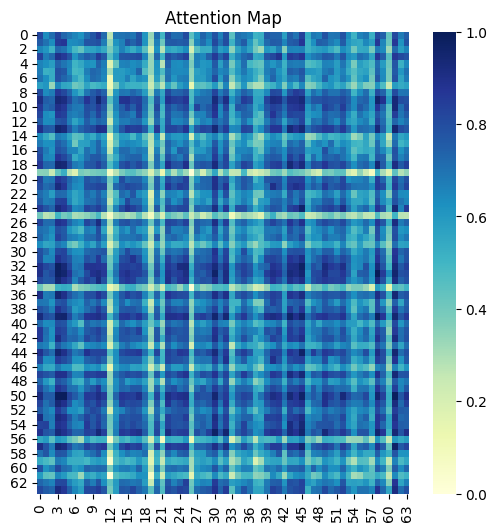

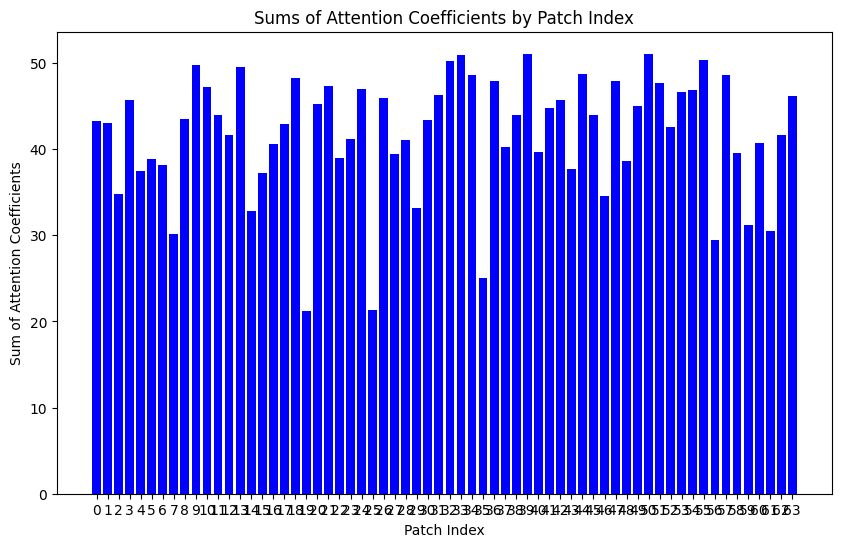

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8438)

tensor(426.1361, grad_fn=<DivBackward1>)


 87%|████████▋ | 26/30 [6:49:10<1:04:18, 964.50s/it]

Complete 25 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.7344, 0.9718, 0.8942,  ..., 0.6382, 0.9880, 0.9744],
         [0.9240, 0.6405, 0.7771,  ..., 0.9726, 0.5895, 0.6334],
         [0.9956, 0.8147, 0.9206,  ..., 0.9977, 0.7692, 0.8085],
         ...,
         [0.9870, 0.9287, 0.9887,  ..., 0.9489, 0.8960, 0.9245],
         [0.9734, 0.7386, 0.8621,  ..., 0.9975, 0.6893, 0.7318],
         [0.8941, 0.9973, 0.9872,  ..., 0.8173, 0.9877, 0.9964]],

        [[0.9524, 0.9890, 0.9286,  ..., 0.9645, 0.9673, 0.6784],
         [0.8086, 0.8877, 0.7693,  ..., 0.8311, 0.9967, 0.4750],
         [0.9473, 0.8857, 0.9676,  ..., 0.9329, 0.6673, 0.9718],
         ...,
         [0.9839, 0.9426, 0.9942,  ..., 0.9753, 0.7544, 0.9274],
         [0.9562, 0.9909, 0.9332,  ..., 0.9678, 0.9639, 0.6863],
         [0.9501, 0.9878, 0.9258,  ..., 0.9625, 0.9691, 0.6739]],

        [[0.8886, 0.8973, 0.8840,  ..., 0.8862, 0.9343, 0.7949],
         [0.9651, 0.9702, 0.9623,  ..., 0.9636, 0.9889, 0.9004],
         [0.9147, 0.9224, 0.9106,  ..., 0.9125, 0.9

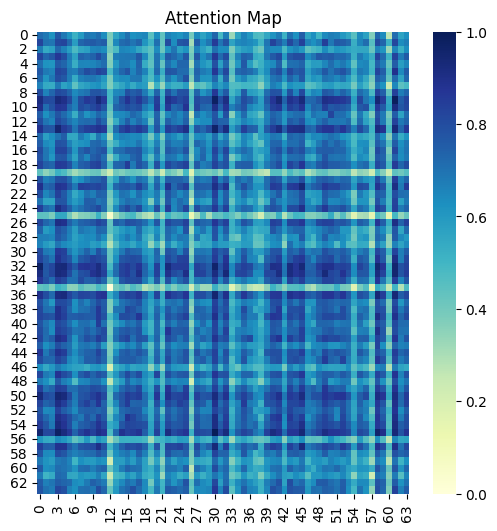

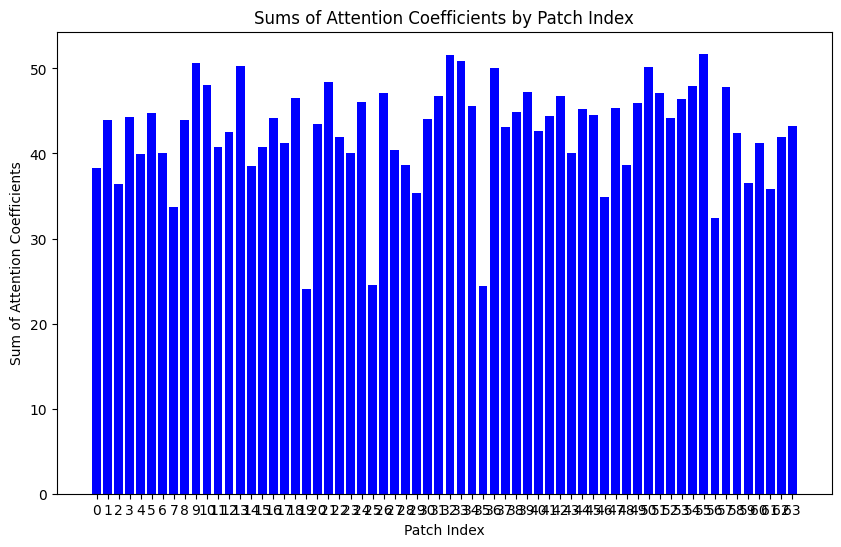

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8375)

tensor(426.1932, grad_fn=<DivBackward1>)


 90%|█████████ | 27/30 [7:04:47<47:48, 956.32s/it]  

Complete 26 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9711, 0.9450, 0.7678,  ..., 0.9548, 0.9686, 0.8197],
         [0.9663, 0.9385, 0.7565,  ..., 0.9488, 0.9635, 0.8092],
         [0.9683, 0.9874, 0.9736,  ..., 0.9818, 0.9709, 0.9909],
         ...,
         [0.9554, 0.9787, 0.9834,  ..., 0.9716, 0.9584, 0.9963],
         [0.8394, 0.8837, 0.9943,  ..., 0.8692, 0.8447, 0.9796],
         [0.9709, 0.9446, 0.7671,  ..., 0.9545, 0.9683, 0.8191]],

        [[0.8697, 0.9912, 0.9028,  ..., 0.9935, 0.9417, 0.9949],
         [0.9999, 0.8096, 0.6253,  ..., 0.9223, 0.9856, 0.8265],
         [0.7896, 0.9997, 0.9579,  ..., 0.9633, 0.8801, 0.9983],
         ...,
         [1.0000, 0.8036, 0.6185,  ..., 0.9181, 0.9837, 0.8207],
         [0.8679, 0.9917, 0.9044,  ..., 0.9930, 0.9404, 0.9953],
         [0.9854, 0.8868, 0.7208,  ..., 0.9711, 0.9999, 0.9006]],

        [[0.9386, 0.9992, 0.6198,  ..., 1.0000, 0.9771, 0.9199],
         [1.0000, 0.9488, 0.8286,  ..., 0.9347, 0.9888, 0.9991],
         [0.9922, 0.9076, 0.8838,  ..., 0.8895, 0.9

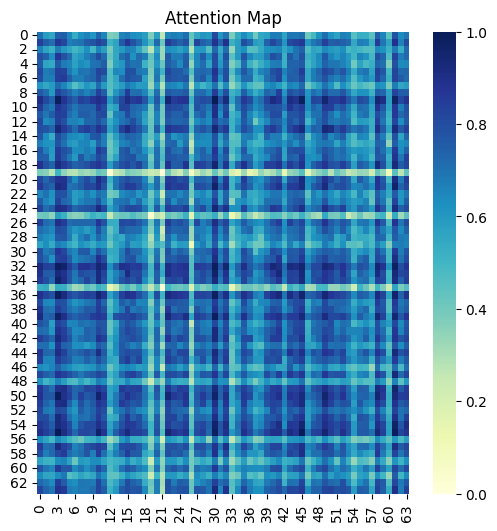

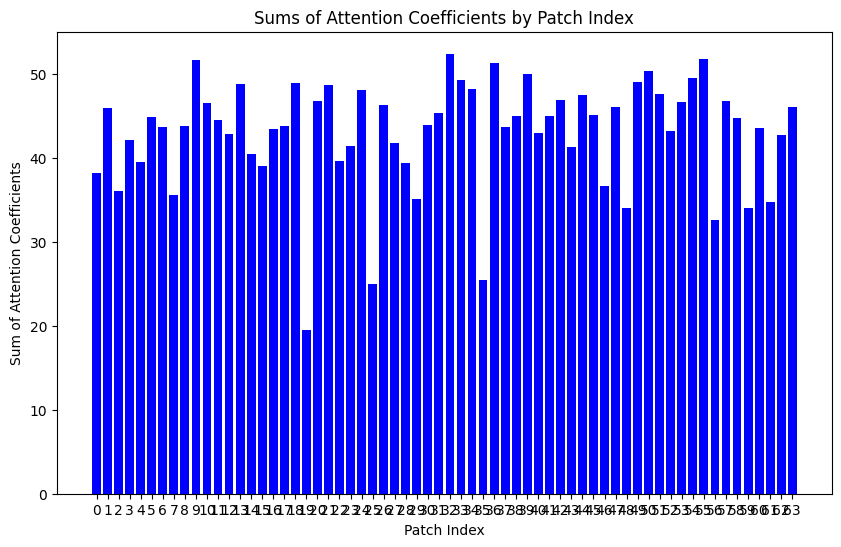

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8562)

tensor(425.8209, grad_fn=<DivBackward1>)


 93%|█████████▎| 28/30 [7:20:16<31:35, 947.95s/it]

Complete 27 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.7069, 0.8908, 0.9846,  ..., 0.9329, 0.5877, 0.8387],
         [0.8468, 0.9751, 0.9968,  ..., 0.9933, 0.7408, 0.9449],
         [0.9813, 0.8613, 0.6960,  ..., 0.8071, 1.0000, 0.9101],
         ...,
         [0.9970, 0.9117, 0.7633,  ..., 0.8652, 0.9928, 0.9508],
         [0.9999, 0.9363, 0.8002,  ..., 0.8951, 0.9826, 0.9691],
         [0.9283, 0.9994, 0.9639,  ..., 0.9972, 0.8433, 0.9894]],

        [[0.8168, 0.9478, 0.8931,  ..., 0.9671, 0.8820, 0.9514],
         [0.9782, 0.8742, 0.9337,  ..., 0.5432, 0.9422, 0.8688],
         [0.7903, 0.9312, 0.8710,  ..., 0.9784, 0.8592, 0.9353],
         ...,
         [0.9245, 0.9962, 0.9726,  ..., 0.8831, 0.9665, 0.9971],
         [0.8673, 0.9750, 0.9328,  ..., 0.9369, 0.9236, 0.9775],
         [0.9815, 0.9933, 0.9995,  ..., 0.7817, 0.9983, 0.9919]],

        [[0.8257, 0.9561, 0.9703,  ..., 0.9206, 0.6519, 0.9835],
         [0.8789, 0.9823, 0.9909,  ..., 0.9572, 0.7178, 0.9974],
         [0.9766, 0.8658, 0.8398,  ..., 0.9117, 0.9

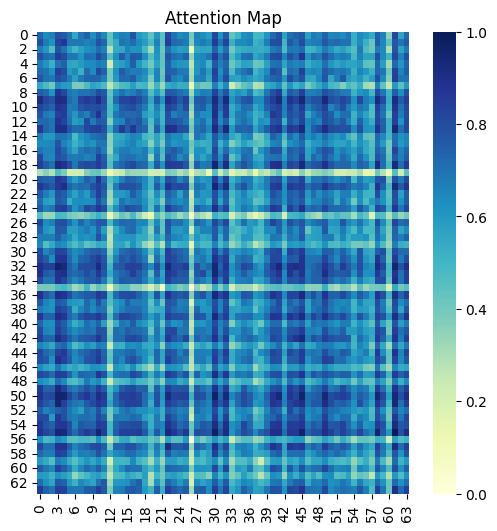

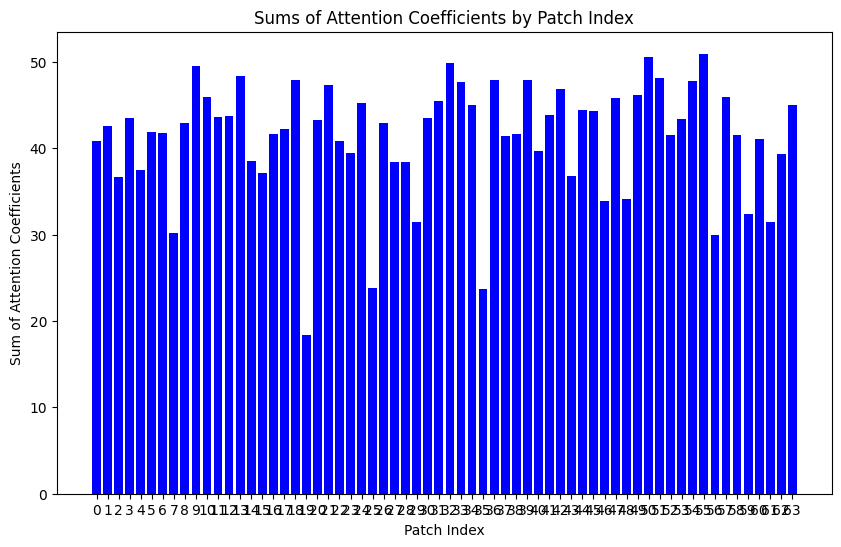

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8438)

tensor(425.4125, grad_fn=<DivBackward1>)


 97%|█████████▋| 29/30 [7:36:14<15:51, 951.01s/it]

Complete 28 th
torch.Size([160, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8122, 0.5959, 0.7937,  ..., 0.7520, 0.7823, 0.8722],
         [0.9024, 0.7111, 0.8877,  ..., 0.8533, 0.8785, 0.9466],
         [0.9962, 0.9601, 0.9986,  ..., 0.9997, 0.9995, 0.9784],
         ...,
         [0.9541, 0.9978, 0.9637,  ..., 0.9808, 0.9690, 0.9122],
         [0.8702, 0.6671, 0.8539,  ..., 0.8162, 0.8436, 0.9211],
         [0.9383, 0.7665, 0.9262,  ..., 0.8968, 0.9184, 0.9728]],

        [[0.9997, 0.9820, 0.9963,  ..., 0.9802, 0.9088, 0.9427],
         [0.9906, 0.9996, 0.9970,  ..., 0.9993, 0.9632, 0.9839],
         [0.9141, 0.9669, 0.9359,  ..., 0.9693, 0.9999, 0.9944],
         ...,
         [0.9704, 0.9967, 0.9830,  ..., 0.9975, 0.9863, 0.9974],
         [0.9377, 0.9814, 0.9564,  ..., 0.9832, 0.9986, 0.9992],
         [0.9982, 0.9750, 0.9928,  ..., 0.9729, 0.8947, 0.9311]],

        [[0.8045, 0.6859, 0.8872,  ..., 0.9618, 0.9743, 0.9244],
         [0.8813, 0.7764, 0.9463,  ..., 0.9926, 0.9975, 0.9717],
         [0.7472, 0.6234, 0.8388,  ..., 0.9293, 0.9

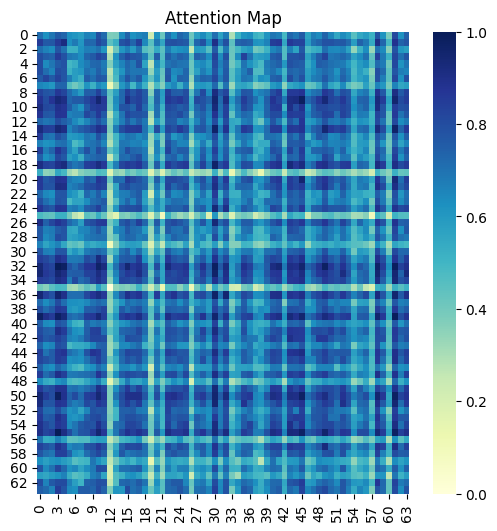

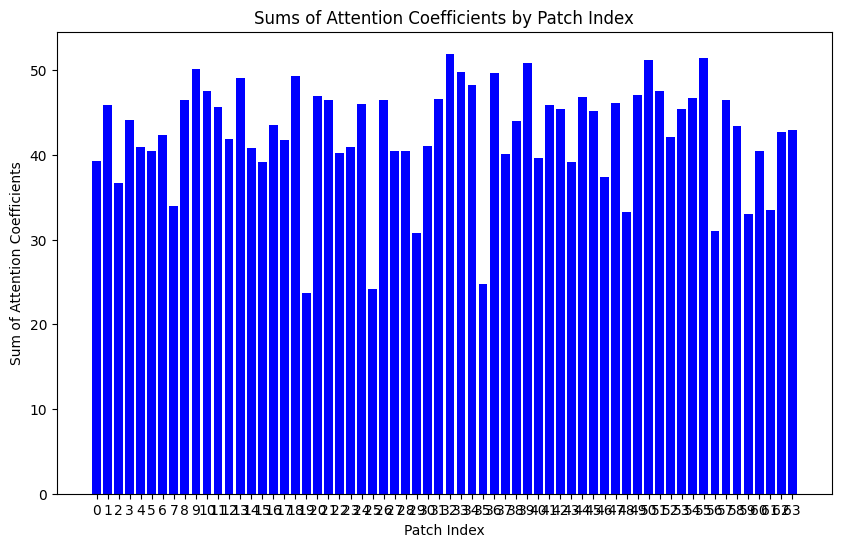

Q_output size: torch.Size([64, 160, 64])
K_output size: torch.Size([64, 160, 64])
V_output size: torch.Size([160, 64, 16])


/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8125)

tensor(425.5307, grad_fn=<DivBackward1>)


100%|██████████| 30/30 [7:51:34<00:00, 943.15s/it]

Complete 29 th


In [22]:
for iepoch in tqdm(range(30)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = binary_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()
    print("Complete "+str(iepoch)+" th")

torch.Size([40, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9233, 0.9221, 0.9946,  ..., 0.9998, 0.9981, 0.9896],
         [0.9187, 0.9175, 0.9957,  ..., 1.0000, 0.9988, 0.9913],
         [0.7319, 0.7300, 0.9599,  ..., 0.9338, 0.9472, 0.9702],
         ...,
         [0.9939, 0.9935, 0.9256,  ..., 0.9534, 0.9407, 0.9105],
         [0.9546, 0.9536, 0.9804,  ..., 0.9934, 0.9879, 0.9718],
         [0.8465, 0.8448, 0.9973,  ..., 0.9877, 0.9932, 0.9994]],

        [[0.7420, 0.9994, 0.8109,  ..., 0.8440, 0.9793, 0.8196],
         [0.8640, 0.9648, 0.9173,  ..., 0.9404, 0.9996, 0.9235],
         [0.9928, 0.6496, 0.9703,  ..., 0.9530, 0.7890, 0.9662],
         ...,
         [0.8169, 0.9852, 0.8777,  ..., 0.9054, 0.9977, 0.8850],
         [0.9618, 0.8692, 0.9882,  ..., 0.9961, 0.9591, 0.9906],
         [0.8490, 0.9725, 0.9049,  ..., 0.9296, 1.0000, 0.9115]],

        [[0.9819, 0.9966, 0.8254,  ..., 0.9968, 0.9314, 0.9691],
         [0.9938, 1.0000, 0.8641,  ..., 1.0000, 0.9566, 0.9854],
         [0.9689, 0.9373, 0.9844,  ..., 0.9364, 0.9

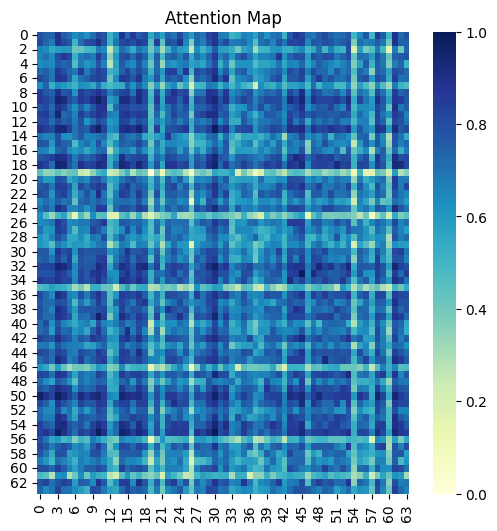

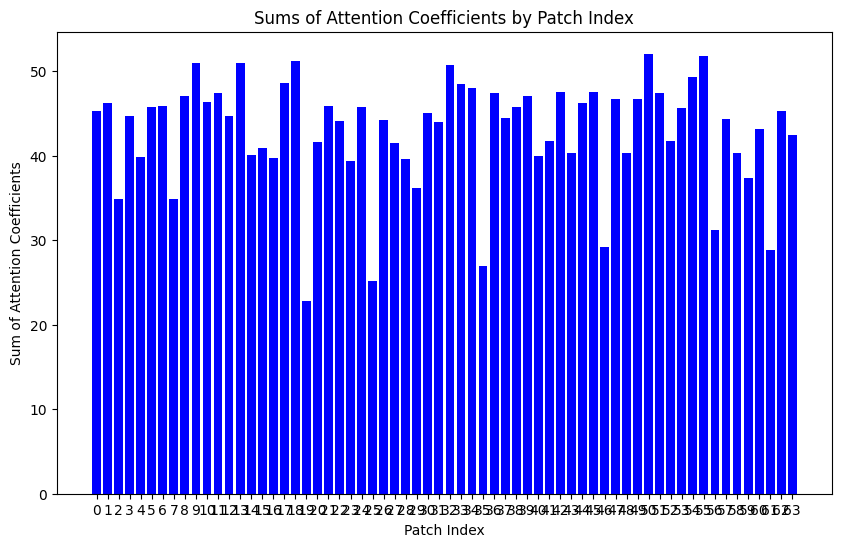

Q_output size: torch.Size([64, 40, 64])
K_output size: torch.Size([64, 40, 64])
V_output size: torch.Size([40, 64, 16])

Accuracy: 0.75

Loss: 45.273887634277344

AUROC: 0.8290598290598291



/tmp/ipykernel_96051/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [23]:
from sklearn.metrics import roc_auc_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)
for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Calculate AUROC
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy
auroc = roc_auc_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')

-----------------------------------------